# ODE   model of NeuroImaging With Bayesian Inference in Multiple Ways

:::{post} April 8, 2024
:tags: ODE, PyTensor, gradient-free and gradien-based (MCMC) inference
:category: Advanced, how-to
:author: Meysam HASHEMI, INS, AMU, Marseille.
:::

Note: This notebook is adpated from PyMC's ODE models, written by Greg Brunkhorst. 
See: 
https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_Lotka_Volterra_multiple_ways.html

In [1]:
import os
import sys
import errno
import time

import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt


from numba import njit
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.integrate import odeint
from scipy.optimize import least_squares

import arviz as az
import matplotlib.pyplot as plt

In [2]:
print(f"Running on PyMC v{pm.__version__}")
print(f"Running on Pytensor v{pytensor.__version__}")
print(f"Running on Numpy v{np.__version__}")
print(f"Running on Arviz v{az.__version__}")

Running on PyMC v5.11.0
Running on Pytensor v2.18.6
Running on Numpy v1.25.2
Running on Arviz v0.18.0


In [3]:
%load_ext watermark
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

In [4]:
import os
import sys
cwd = os.getcwd()
output_dir= cwd + '/output_pymc/'
! mkdir -p $output_dir

/bin/bash: /home/meysam/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


## Purpose

The purpose of this notebook is to demonstrate how to perform Bayesian inference on a system of ordinary differential equations (ODEs), both with and without gradients. The code is adapted from PyMC ODE examples (Ref [1]).   The accuracy and efficiency of different samplers are compared. The application is to model and fit Event-Related Responses (ERPs) measured with EEG/MEG data (see Ref [2]).

Although recently have been some effort to Bayesian inversion of this model in dynamic causal modeling Refs [3,4], here we benifit from automatic algorithms and automatic gradient calculation in PPLs such as PyMC, which also provides different MCMC samplers.

We will first solve the ODE using `scipy.odeint` spped up using Numba's JIT, and (non-Bayesian) least squares optimization.  Next, we perform Bayesian inference in PyMC using non-gradient-based samplers (Slice/Metropolis/DE MetropolisZ/DEMetropolis). We show also the simualtion-based method such as SMC.  Finally, we use gradient-based samplers (NUTS) using different backends (PyMC ODE/ Pytensor Scan/ Nutpie/ Balckjax/ Numpyro) and compare results.    

### Key Conclusions

Based on the experiments in this notebook, the most simple and efficient method for performing Bayesian inference on this model was to specify the ODE system in Scipy, wrap the function as a Pytensor op, and use a NUTS  sampler in Blackjax/Numpyro.   

Refs: 

1) https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_Lotka_Volterra_multiple_ways.html


2) https://www.sciencedirect.com/science/article/abs/pii/S1053811905008013


3) https://www.sciencedirect.com/science/article/pii/S1053811915001846


4) https://www.sciencedirect.com/science/article/pii/S1053811915006540


## Background

### Motivation

Ordinary differential equation models (ODEs) are used in a variety of science and engineering domains to model the time evolution of physical variables.  A natural choice to estimate the values and uncertainty of model parameters given experimental data is Bayesian inference.  However, ODEs can be challenging to specify and solve in the Bayesian setting, therefore, this notebook steps through multiple methods for solving an ODE inference problem using PyMC. The apadted Jansen-Rit model used in this example has often been used in dynamical cuasal modeling and other approaches to fit various neuroimaging data such as ERP/EEG/MEG.

### Neural Mass Model 


The mode of olivier david et al describes the interaction between theree neural populations of pyramidal (x9), 
inhibitory interneuron (x7) 
spiny-stellate cells (x1).

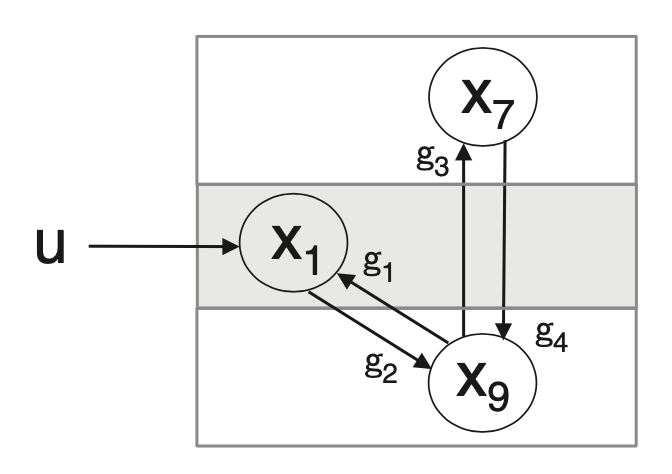

In [5]:
from IPython.display import Image
Image(filename='model.png', width=400) 

This ODE given by:




\begin{array}{l}
\frac{dx_{1}(t)}{dt} = x_{4}(t) \\
\frac{dx_{2}(t)}{dt} = x_{5}(t) \\
\frac{dx_{3}(t)}{dt} = x_{6}(t) \\
\frac{dx_{7}(t)}{dt}  = x_{8}(t) \\
\frac{dx_{4}(t)}{dt} = \frac{{h_{e}(g_{1}(\frac{1}{e^{-0.56x_{9}(t-\delta)}+1} - 0.5) + u)}}{{\tau_{e}}} - \frac{{x_{1}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{4}(t)}}{{\tau_{e}}} \\
\frac{dx_{5}(t)}{dt}  = \frac{{g_{2}(\frac{1}{e^{-0.56x_{1}(t-\delta)}+1} - 0.5)}}{{\tau_{e}}} - \frac{{x_{2}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{5}(t)}}{{\tau_{e}}} \\
\frac{dx_{6}(t)}{dt}  = \frac{{g_{4}(\frac{1}{e^{-0.56x_{7}(t-\delta)}+1} - 0.5)}}{{\tau_{i}}} - \frac{{x_{3}(t)}}{{\tau_{i}^{2}}} - \frac{{2x_{6}^{t}}}{{\tau_{i}}} \\
\frac{dx_{8}(t)}{dt}  = \frac{{g_{3}(\frac{1}{e^{-0.56x_{9}(t-\delta)}+1} - 0.5)}}{{\tau_{e}}} - \frac{{x_{7}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{8}(t)}}{{\tau_{e}}} \\
\frac{dx_{9}(t)}{dt}  = x_{5}(t) - x_{6}(t)
\end{array}



The state vector $X(t)=[x_1(t), ...x_9(t)]$ comprises the densities of activity of nerural populations.  Parameters $\boldsymbol{\theta}=[g_1, g_2, g_3, g_4, \delta,\tau_i, h_i, \tau_e, h_e, u ]$ are the unknowns that we wish to infer from experimental observations.  

$x(0)$ is the initial values of the states needed to solve the ODE, and are fixed to zero for all variables. 


The unknown model parameters which represent the following:  
* $g_1, g_2, g_3, g_4$ are connection strengths.
* $\delta$ is the intrinsic delay.
* $h_{e,i}$ are maximum amplitude of excitatory (e), and inhibitory (i) post-synaptic potential.
* $\tau_{e, i}$ are the excitatory (e), and inhibitory (i) rate-constant of the membrane,
* $u$  is the input to the neural population.

### Set-up

In [6]:
params_labels=['$g_1$', '$g_2$', '$g_3$', '$g_4$', '$\delta$', '$tau_i$', '$h_i$', '$tau_e$','$h_e$', '$u$']
my_var_names = ['g_1', 'g_2', 'g_3', 'g_4', 'delta', 'tau_i', 'h_i', 'tau_e', 'h_e', 'u']

In [7]:
t0=0.0
tend = 200.0
dt=0.1
ts = np.arange(t0, tend + dt, dt)

In [8]:
n_time=ts.shape[0]
n_states=9
n_time, n_states

(2001, 9)

In [9]:
x_init=np.zeros((n_states))

In [10]:
g_1=0.42
g_2=0.76
g_3=0.15
g_4=0.16
delta=12.13
tau_e=5.77
h_i=27.87
tau_i=7.77
h_e=1.63
u=3.94

In [11]:
sigma_true=0.1

In [12]:
theta_true = np.array([g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u])
n_params = theta_true.shape[0]

In [13]:
c=-0.56
constants=np.array([c])

In [14]:
@njit
def Sigmodal(x1, x2, delta, c):
    S=(1./(1.+np.exp(c*(x1-(delta*x2)))))-0.5
    return S

## Scipy `odeint`

Here, we make a Python function that represents the right-hand-side of the ODE equations with the call signature needed for the `odeint` function.  Note that Scipy's `solve_ivp` could also be used, but the older `odeint` function was faster in speed tests and is therefore used in this notebook.  

In [15]:
# define the right hand side of the ODE equations in the Scipy odeint signature

@njit
def DCM_ERPmodel(states, t, params):
    
    # state variables
    x0, x1, x2, x3, x4, x5, x6, x7, x8 = states
    
    # unpack parameters
    g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u  = params

    #constants
    c = constants[0]
        
    # equations
    dx0_dt = x3
    dx1_dt = x4
    dx2_dt = x5
    dx3_dt = (1./tau_e) * (h_e * (g_1 * (Sigmodal(x8, x4 - x5, delta, c)) + u) - (x0 / tau_e) - 2 * x3)
    dx4_dt = (1./tau_e) * (h_e * (g_2 * (Sigmodal(x0, x3, delta, c))) - (x1 / tau_e) - 2 * x4)
    dx5_dt = (1./tau_i) * (h_i * (g_4 * (Sigmodal(x6, x7, delta, c))) - (x2 / tau_i) - 2 * x5)
    dx6_dt = x7
    dx7_dt = (1. / tau_e) * (h_e * (g_3 * (Sigmodal(x8, x4 - x5, delta, c))) - (x6 / tau_e) - 2 * x7)
    dx8_dt = x4 - x5
    
    return [dx0_dt, dx1_dt, dx2_dt, dx3_dt, dx4_dt, dx5_dt, dx6_dt, dx7_dt, dx8_dt]

To get a feel for the model and make sure the equations are working correctly, let's run the model once with reasonable values for $\theta$ and plot the results.  

In [16]:
# plot model function
def plot_model(ax, xs, ts=np.arange(t0, tend + dt, dt), alpha=1, lw=2, title="ERP and an Example Model Run",):
    ax.plot(ts, xs[:, 8], color="cornflowerblue", alpha=alpha, lw=lw, label="Pyramidal (Model)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)
    return ax

In [17]:
theta = theta_true
ts = np.arange(t0, tend + dt, dt)

# call Scipy's odeint function
xs= odeint(DCM_ERPmodel, x_init, t=ts, args=(theta,))

### Synthetic observation

We assume that we only have accessto the activity of pyramidfal neurons, and for the sake of sppeding the computational time, we downsample the simuations.

In [18]:
#Downsamplinmg
ds=10

In [19]:
ts_obs=ts[::ds]
xpy_ds=xs[:, 8][::ds]

In [20]:
x_noise = np.random.normal(loc=0, scale=sigma_true, size=xpy_ds.shape[0])
xpy_obs = xpy_ds + x_noise

In [21]:
# fmt: off
data = pd.DataFrame(dict(
    ts_obs = ts_obs,
    pyramidal = xpy_obs,))
data.head()
# fmt: on

ts_obs  pyramidal
0     0.0  -0.127403
1     1.0  -0.048027
2     2.0  -0.130093
3     3.0  -0.276918
4     4.0  -0.586375

In [22]:
# plot data function for reuse later
def plot_data(ax, lw=0, title="Synthetic ERP data"):
    ax.plot(data.ts_obs, data.pyramidal, color="red", lw=lw, marker="x", markersize=4, label="Pyramidal (Data)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlim([0, 200])
    ax.set_xlabel("time [ms]", fontsize=14)
    ax.set_ylabel("voltage [mv] ", fontsize=14)
    ax.set_title(title, fontsize=16)
    return ax

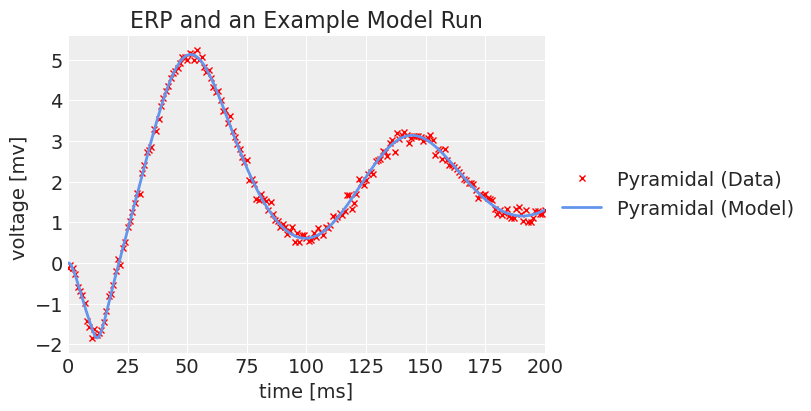

In [23]:
# plot
_, ax = plt.subplots(figsize=(8, 4))
plot_data(ax);
plot_model(ax, xs);

PPC

In [24]:
def rmse_fit(model, trace, data, theta_true):
#     with model:
#          pp = pm.sample_posterior_predictive(trace,  var_names=["xpy_obs"], predictions=True, random_seed=rng)
#          theta_err=np.sum((theta_true-az.summary(trace, var_names=my_var_names).values[:,0])**2)
#          x_ppc=np.mean(np.mean(pp.predictions['xpy_obs'][:,:,:,0], axis=0), axis=0)
#          xs_err=np.sum((x_ppc-data.pyramidal)**2)

    theta_mean=np.mean(az.extract(trace).to_dataframe()[my_var_names], axis=0).to_numpy()
    theta_err=np.sum(theta_mean-theta_true)**2
    xs_= odeint(DCM_ERPmodel, x_init, t=ts, args=(theta_mean,))
    xs_err=np.sum((xs_[:,8][::ds]-data["pyramidal"])**2)
    
    return (theta_err), np.mean(xs_err)

Looks like the `odeint` function is working as expected.  

## Least Squares Solution

Now, we can solve the ODE using least squares.  Make a function that calculates the residual error.  

In [25]:
# function that calculates residuals based on a given theta
def ode_model_resid(theta):
    return (data[["pyramidal"]] - odeint(func=DCM_ERPmodel, y0=x_init, t=ts, args=(theta,))[:,8][::ds].reshape(-1, 1)
           ).values.flatten()

Feed the residual error function to the Scipy `least_squares` solver.   

In [26]:
# calculate least squares using the Scipy solver
results = least_squares(ode_model_resid, x0=theta)

In [27]:
# put the results in a dataframe for presentation and convenience
df = pd.DataFrame()
parameter_names = my_var_names
df["Parameter"] = my_var_names
df["Ground true"] = theta_true
df["Least Squares Solution"] = results.x
df.round(2)

Parameter  Ground true  Least Squares Solution
0       g_1         0.42                   -0.04
1       g_2         0.76                    1.22
2       g_3         0.15                    0.36
3       g_4         0.16                    0.10
4     delta        12.13                   13.24
5     tau_i         7.77                    7.71
6       h_i        27.87                   27.87
7     tau_e         5.77                    5.25
8       h_e         1.63                    1.07
9         u         3.94                    3.58

Plot  LSE

In [28]:
xs_lse = odeint(func=DCM_ERPmodel, y0=x_init, t=ts, args=(results.x,))

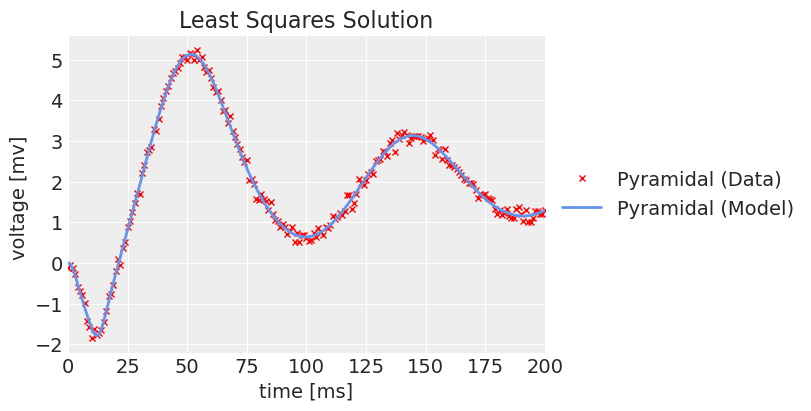

In [29]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_data(ax, lw=0);
plot_model(ax, xs_lse, title="Least Squares Solution");

Looks right.  If we didn't care about uncertainty, then we would be done.  But we do care about uncertainty, so let's move on to Bayesian inference.  

## PyMC Model Specification for Gradient-Free Bayesian Inference

Like other Numpy or Scipy-based functions, the `scipy.integrate.odeint` function cannot be used directly in a PyMC model because PyMC needs to know the variable input and output types to compile.  Therefore, we use a Pytensor wrapper to give the variable types to PyMC.  Then the function can be used in PyMC in conjunction with gradient-free samplers.   

### Convert Python Function to a Pytensor Operator using @as_op decorator
We tell PyMC the input variable types and the output variable types using the `@as_op` decorator.  `odeint` returns Numpy arrays, but we tell PyMC that they are Pytensor double float tensors for this purpose.  

In [30]:
# decorator with input and output types a Pytensor double float tensors
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    return odeint(func=DCM_ERPmodel, y0=x_init, t=ts, args=(theta,))

### PyMC Model

 we place Gamma prior on all parameters, and we run the chain at the tail of prior.

In [31]:
shape=[18.16, 29.9, 29.14, 30.77, 22.87, 34.67, 20.44, 33.02, 24.17, 23.62]
scale=[0.03, 0.02, 0.005, 0.007, 0.51, 0.23, 0.96, 0.16, 0.07, 0.13]
rate = 1. / np.array(scale)

In [32]:
prior_specs = dict(shape=shape, rate=rate)

Initializing at the tail of prior

In [33]:
with pm.Model() as prior_model:
    # Priors
    g_1 = pm.Gamma("g_1", alpha=prior_specs['shape'][0], beta=prior_specs['rate'][0])
    g_2 = pm.Gamma("g_2", alpha=prior_specs['shape'][1], beta=prior_specs['rate'][1])
    g_3 = pm.Gamma("g_3", alpha=prior_specs['shape'][2], beta=prior_specs['rate'][2])
    g_4 = pm.Gamma("g_4", alpha=prior_specs['shape'][3], beta=prior_specs['rate'][3])
    delta = pm.Gamma("delta", alpha=prior_specs['shape'][4], beta=prior_specs['rate'][4])
    tau_i = pm.Gamma("tau_i", alpha=prior_specs['shape'][5], beta=prior_specs['rate'][5])
    h_i = pm.Gamma("h_i", alpha=prior_specs['shape'][6], beta=prior_specs['rate'][6])
    tau_e = pm.Gamma("tau_e", alpha=prior_specs['shape'][7], beta=prior_specs['rate'][7])
    h_e = pm.Gamma("h_e", alpha=prior_specs['shape'][8], beta=prior_specs['rate'][8])
    u = pm.Gamma("u", alpha=prior_specs['shape'][9], beta=prior_specs['rate'][9])

In [34]:
n_=100

In [35]:
with prior_model:
        prior_predict= pm.sample_prior_predictive(n_)

Sampling: [delta, g_1, g_2, g_3, g_4, h_e, h_i, tau_e, tau_i, u]


In [36]:
def tails_percentile(my_var_names, prior_predictions, thr):
    tails_xth_percentile = {}
    for key, value in prior_predictions.items():
        if key in my_var_names:
            sorted_values = np.sort(value)[0, :] if value.shape[0] == 1 else np.sort(value)
            top_xth_percentile = sorted_values[int(0.05 * len(sorted_values))]
            tails_xth_percentile[key] = np.array(top_xth_percentile)
    return tails_xth_percentile

In [37]:
tails_5th_percentile=tails_percentile(my_var_names, prior_predict.prior, 0.05)    
tails_5th_percentile

{'delta': array(8.38937983),
 'g_1': array(0.3214632),
 'g_2': array(0.45029027),
 'g_3': array(0.10584942),
 'g_4': array(0.15860265),
 'h_e': array(1.15925745),
 'h_i': array(11.77912973),
 'tau_e': array(3.96537918),
 'tau_i': array(6.24862903),
 'u': array(2.21645146)}

In [38]:
with pm.Model() as model:
    # Priors
    g_1 = pm.Gamma("g_1", alpha=prior_specs['shape'][0], beta=prior_specs['rate'][0])
    g_2 = pm.Gamma("g_2", alpha=prior_specs['shape'][1], beta=prior_specs['rate'][1])
    g_3 = pm.Gamma("g_3", alpha=prior_specs['shape'][2], beta=prior_specs['rate'][2])
    g_4 = pm.Gamma("g_4", alpha=prior_specs['shape'][3], beta=prior_specs['rate'][3])
    delta = pm.Gamma("delta", alpha=prior_specs['shape'][4], beta=prior_specs['rate'][4])
    tau_i = pm.Gamma("tau_i", alpha=prior_specs['shape'][5], beta=prior_specs['rate'][5])
    h_i = pm.Gamma("h_i", alpha=prior_specs['shape'][6], beta=prior_specs['rate'][6])
    tau_e = pm.Gamma("tau_e", alpha=prior_specs['shape'][7], beta=prior_specs['rate'][7])
    h_e = pm.Gamma("h_e", alpha=prior_specs['shape'][8], beta=prior_specs['rate'][8])
    u = pm.Gamma("u", alpha=prior_specs['shape'][9], beta=prior_specs['rate'][9])
    
    params_samples=[g_1, g_2, g_3, g_4, delta, tau_i,  h_i, tau_e, h_e, u]
    
    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(pm.math.stack(params_samples))
    xpy_hat=ode_solution[:, 8][::ds][:, np.newaxis]
    
    # Likelihood
    pm.Normal("xpy_obs", mu=xpy_hat, sigma=sigma_true, observed=data[["pyramidal"]].values)

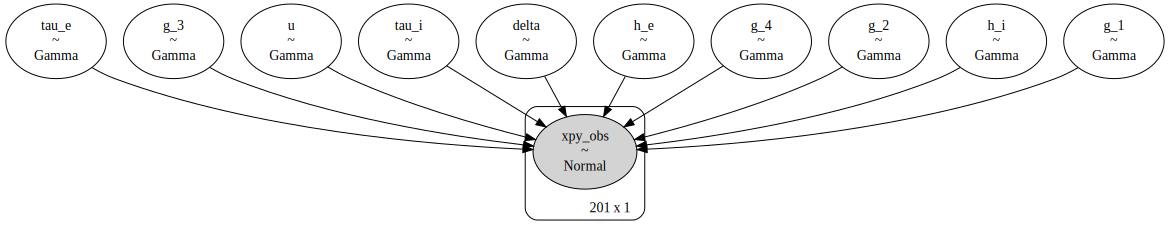

In [39]:
pm.model_to_graphviz(model=model)

In [40]:
model.debug()

point={'g_1_log__': array(-0.60733652), 'g_2_log__': array(-0.51416453), 'g_3_log__': array(-1.92620557), 'g_4_log__': array(-1.53530494), 'delta_log__': array(2.45648145), 'tau_i_log__': array(2.07619879), 'h_i_log__': array(2.97667177), 'tau_e_log__': array(1.66453197), 'h_e_log__': array(0.52585216), 'u_log__': array(1.12187298)}

No problems found


### Plotting Functions
A couple of plotting functions that we will reuse below.  

In [41]:
def plot_model_trace(ax, trace_df, row_idx, lw=1, alpha=0.2):
    cols = ['g_1', 'g_2', 'g_3', 'g_4', 'delta', 'tau_i', 'h_i', 'tau_e', 'h_e', 'u']
    row = trace_df.iloc[row_idx, :][cols].values
    ts = np.arange(t0, tend + dt, dt)
    theta = row
    xs= odeint(DCM_ERPmodel, x_init, t=ts, args=(theta,))
    plot_model(ax, xs, ts=ts, lw=lw, alpha=alpha);

In [42]:
def plot_inference(ax,trace, num_samples=20, 
                   title="Evoked Related Potential (ERP)", plot_model_kwargs=dict(lw=1, alpha=0.2),):
    trace_df = az.extract(trace, num_samples=num_samples).to_dataframe()
    plot_data(ax, lw=0)
    for row_idx in range(num_samples):
        plot_model_trace(ax, trace_df, row_idx, **plot_model_kwargs)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)

In [43]:
def plot_joint_post(ax, trace, var_name1, var_name2, my_var_names, theta_true, alpha=1, lw=3, title="Joint Posterior"):
    var_index1 = my_var_names.index(var_name1)
    var_index2 = my_var_names.index(var_name2)
    ax.plot(trace.posterior[f"{var_name1}"].values, trace.posterior[f"{var_name2}"].values, '.',  markersize=4,color='b')
    ax.plot(theta_true[var_index1], theta_true[var_index2], 'o', color='red', markersize=10)  # Add circle for true values
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(f"{var_name1}", fontsize=14)
    ax.set_ylabel(f"{var_name2}", fontsize=14)
    return ax

In [44]:
def plot_trace(trace, my_var_names, theta_true, sampler):
    axes = az.plot_trace(trace,var_names=my_var_names,compact=True, kind="trace",
        backend_kwargs={"figsize": (8, 10), "layout": "constrained"},)

    for ax, true_val in zip(axes[:, 0], theta_true):
        ax.axvline(x=true_val, color='red', linestyle='--')
    for ax, true_val in zip(axes[:, 1], theta_true):
        ax.axhline(y=true_val, color='red', linestyle='--')
        plt.tight_layout();
        
    plt.suptitle(f"Trace Plot {sampler}");
    return axes     


## Gradient-Free Sampler Options
Having good gradient free samplers can open up the models that can be fit within PyMC.  There are five options for gradient-free samplers in PyMC that are applicable to this problem: 
* `Slice` - the default gradient-free sampler
* `DEMetropolisZ` - a differential evolution Metropolis sampler that uses the past to inform sampling jumps
* `DEMetropolis` - a differential evolution Metropolis sampler
* `Metropolis` - the vanilla Metropolis sampler
* `SMC` - Sequential Monte Carlo  

Let's give them a shot.

A few notes on running these inferences.  For each sampler, the number of tuning steps and draws have been reduced to run the inference in a reasonable amount of time (on the order of minutes).  This is not a sufficient number of draws to get a good inferences, in some cases, but it works for demonstration purposes.  In addition, multicore processing was not working for the Pytensor op function on all machines, so inference is performed on one core.         

In [45]:
tune, draws, n_chains = 200, 200, 4

In [46]:
# Variable list to give to the sample step parameter
vars_list = list(model.values_to_rvs.keys())[:-1]

### Slice Sampler

 Slice Sampler is so slow and its compiling takes a lot of time. so we just run it with a few samples

In [47]:
sampler = "Slice Sampler"

start_time = time.time()
with model:
    trace_slice = pm.sample(step=[pm.Slice(vars_list)], tune=tune, draws=draws, chains=n_chains, 
                            initvals={var_name: tails_5th_percentile[var_name] for var_name in my_var_names}
                           ) 
crudetime_slice=time.time() - start_time
print("---running took: %s seconds ---" % crudetime_slice)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [g_1]
>Slice: [g_2]
>Slice: [g_3]
>Slice: [g_4]
>Slice: [delta]
>Slice: [tau_i]
>Slice: [h_i]
>Slice: [tau_e]
>Slice: [h_e]
>Slice: [u]


/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 60 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates p

---running took: 71.06430339813232 seconds ---


In [48]:
trace = trace_slice
az.summary(trace)

mean       sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
delta   12.952    1.689  10.739   15.970      0.824    0.629       5.0   
g_1      0.408    0.251   0.009    0.727      0.112    0.085       7.0   
g_2      0.852    0.429   0.467    1.586      0.210    0.161       5.0   
g_3      0.112    0.163   0.001    0.407      0.080    0.061       4.0   
g_4      0.462    0.311   0.233    1.055      0.152    0.116       5.0   
h_e      2.132    1.131   0.775    4.040      0.553    0.422       4.0   
h_i    178.509  162.824  11.957  444.279     79.356   60.537       4.0   
tau_e    5.425    0.794   4.085    6.480      0.388    0.296       5.0   
tau_i    7.722    0.154   7.448    7.977      0.067    0.051       5.0   
u        2.716    1.587   0.205    4.739      0.749    0.568       5.0   

       ess_tail  r_hat  
delta      12.0   3.29  
g_1        82.0   1.57  
g_2        11.0   3.48  
g_3        11.0   4.53  
g_4        12.0   3.48  
h_e        12.0   3.78  
h_i        12.0   4.13  
tau_e      12.0   3.16  
tau_i      12.0   2.15  
u          15.0   2.34

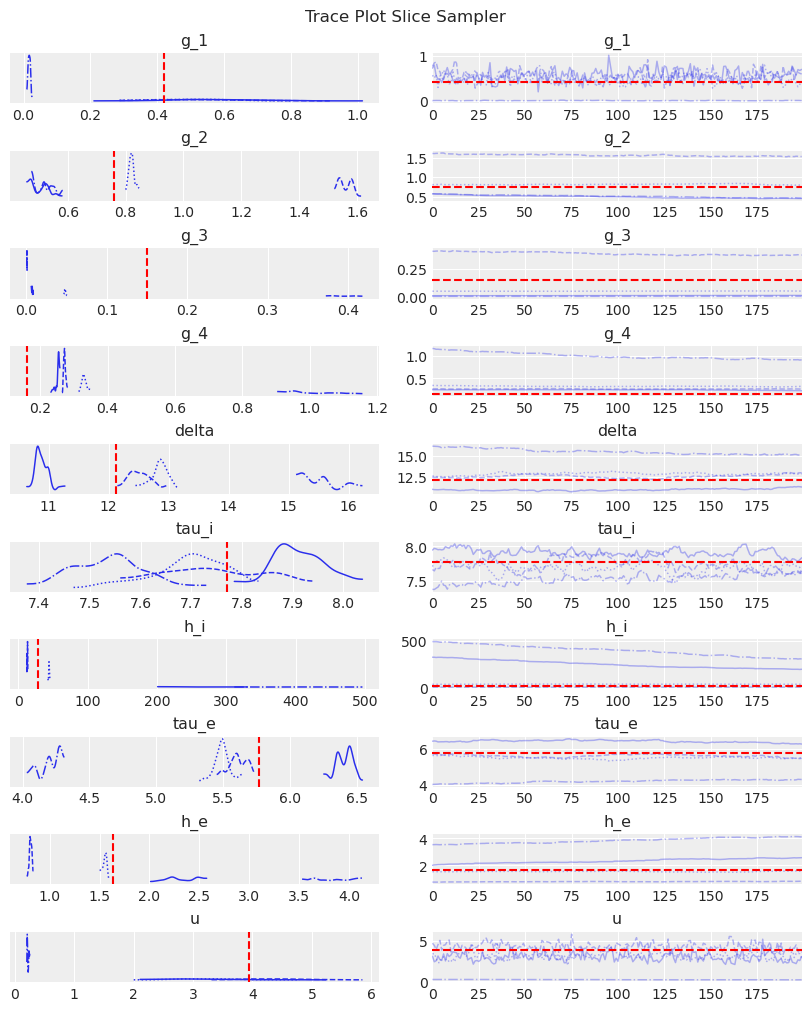

In [49]:
plot_trace(trace, my_var_names, theta_true, sampler);

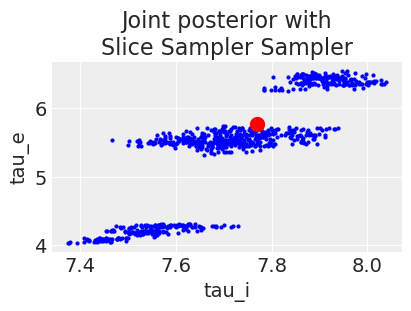

In [50]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

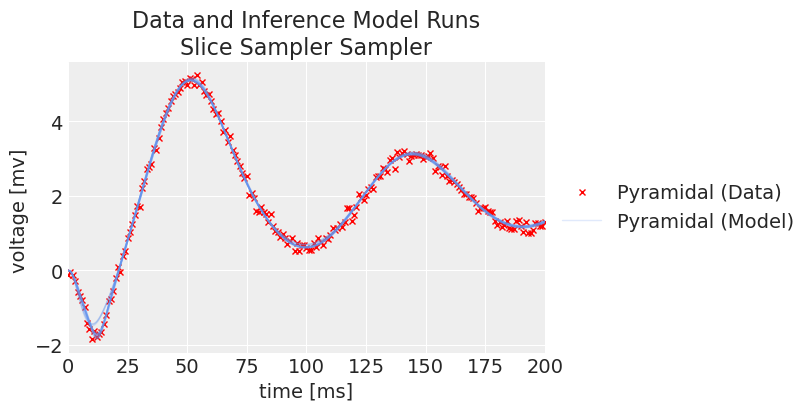

In [51]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [52]:
rmse_params_slice, rmse_fit_slice  =rmse_fit(model, trace, data, theta_true )
print ('RMSE to true parameters', rmse_params_slice),
print ('RMSE to true observation', rmse_fit_slice)

RMSE to true parameters 22707.33879727909
RMSE to true observation 285634.95288763556


**Notes:**  
The Slice sampler was so slow and resulted in a low effective sample size. Moreover, the sampler cannot converge for this problem, hence the fit deviates from observation!  

### Metropolis Sampler

In [53]:
sampler = "Metropolis"

start_time = time.time()
with model:
    trace_M = pm.sample(step=[pm.Metropolis(vars_list)], tune=tune, draws=draws, chains=n_chains,
                       initvals={var_name: tails_5th_percentile[var_name] for var_name in my_var_names}
                       )
crudetime_M=time.time() - start_time
print("---running took: %s seconds ---" % crudetime_M)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [g_1]
>Metropolis: [g_2]
>Metropolis: [g_3]
>Metropolis: [g_4]
>Metropolis: [delta]
>Metropolis: [tau_i]
>Metropolis: [h_i]
>Metropolis: [tau_e]
>Metropolis: [h_e]
>Metropolis: [u]


/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 29 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See htt

---running took: 39.27637553215027 seconds ---


In [54]:
trace = trace_M
az.summary(trace)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
delta  18.275  10.582  11.079   36.490      5.184    3.958       4.0   
g_1     0.211   0.137   0.015    0.428      0.061    0.046       6.0   
g_2     0.674   0.165   0.427    0.876      0.081    0.062       4.0   
g_3     0.138   0.070   0.077    0.267      0.034    0.026       4.0   
g_4     0.377   0.195   0.121    0.645      0.095    0.073       4.0   
h_e     2.340   0.821   1.447    3.613      0.402    0.307       4.0   
h_i    18.608  11.200   4.724   34.881      5.487    4.189       4.0   
tau_e   4.894   0.919   3.319    5.899      0.450    0.344       4.0   
tau_i   6.935   2.835   2.001    8.976      1.388    1.060       4.0   
u       3.349   1.892   0.363    5.633      0.876    0.663       6.0   

       ess_tail  r_hat  
delta       5.0   5.20  
g_1        25.0   2.00  
g_2         5.0   5.09  
g_3         5.0   7.01  
g_4         4.0  15.75  
h_e         5.0   5.73  
h_i         5.0   4.51  
tau_e       8.0   4.71  
tau_i       8.0   5.17  
u           5.0   1.90

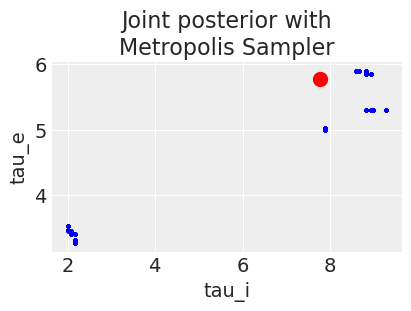

In [55]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


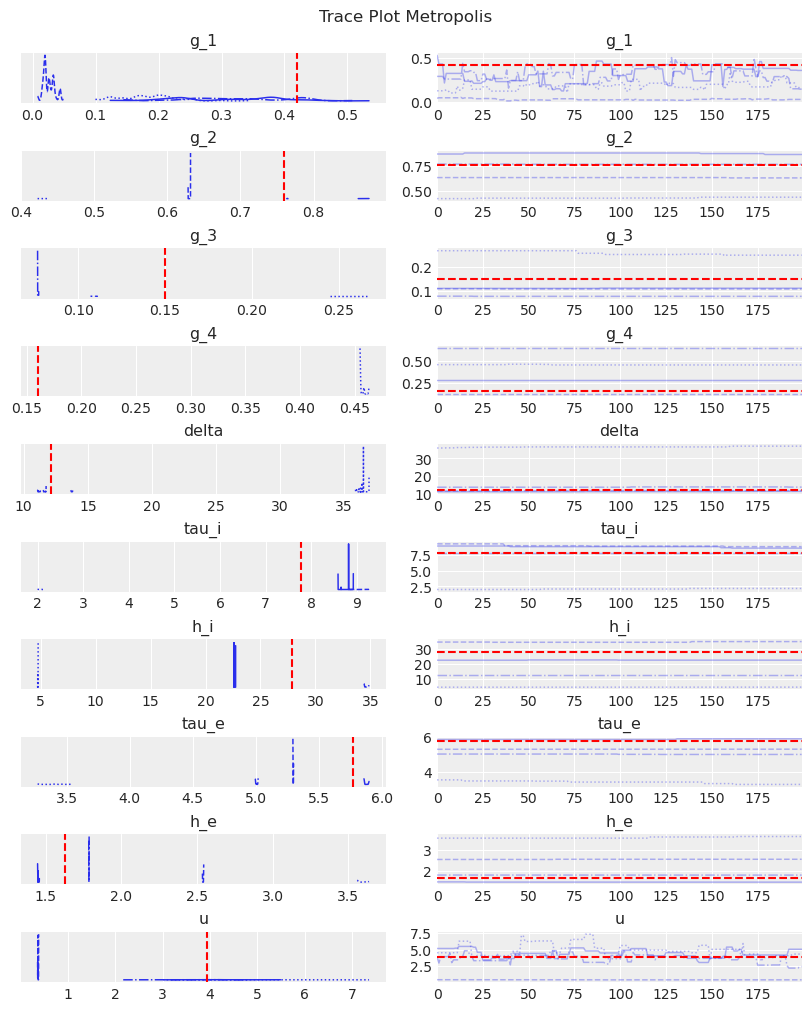

In [56]:
plot_trace(trace, my_var_names, theta_true, sampler);

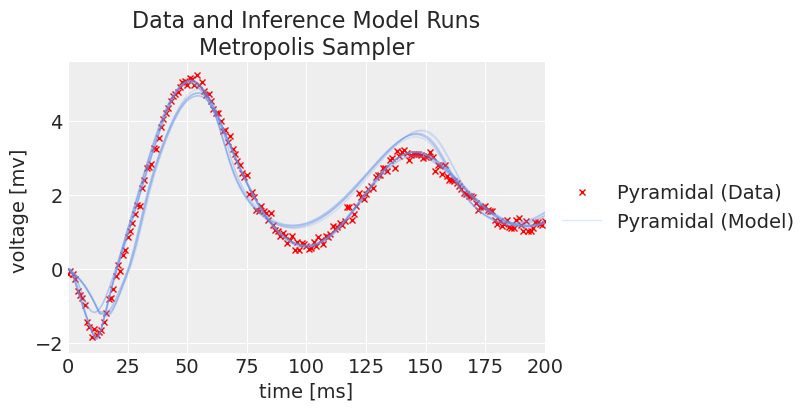

In [57]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [58]:
rmse_params_M, rmse_fit_M=rmse_fit(model, trace, data, theta_true )
print ('RMSE to true parameters', rmse_params_M),
print ('RMSE to true observation', rmse_fit_M)

RMSE to true parameters 23.017260717337884
RMSE to true observation 3061.802570344049


**Notes:**  
The old-school Metropolis sampler is not also reliable. Not recommended.   

### DE MetropolisZ Sampler

In [59]:
sampler = "DE MetropolisZ"

start_time = time.time()
with model:
   trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ(vars_list)], tune=tune, draws=draws, chains=n_chains,
                            initvals={var_name: tails_5th_percentile[var_name] for var_name in my_var_names}
                         ) 
crudetime_DEMZ=time.time() - start_time
print("---running took: %s seconds ---" % crudetime_DEMZ)

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u]


/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:1020: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:1020: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:1020: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:1020: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than

---running took: 6.404308795928955 seconds ---


In [60]:
trace = trace_DEMZ
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
delta   7.236  2.442   3.761   11.201      1.189    0.907       5.0      16.0   
g_1     0.469  0.191   0.215    0.814      0.092    0.070       5.0      12.0   
g_2     0.547  0.070   0.425    0.636      0.033    0.025       5.0      12.0   
g_3     0.147  0.053   0.088    0.234      0.026    0.020       5.0      13.0   
g_4     0.273  0.115   0.129    0.444      0.056    0.043       5.0      11.0   
h_e     1.655  0.531   1.129    2.765      0.252    0.192       5.0      10.0   
h_i    12.371  4.473   6.668   17.731      2.164    1.649       5.0      15.0   
tau_e   9.316  3.969   4.409   15.674      1.921    1.464       5.0      12.0   
tau_i   7.787  2.865   3.969   12.945      1.376    1.051       5.0      21.0   
u       1.589  0.685   0.876    2.886      0.334    0.255       5.0      17.0   

       r_hat  
delta   3.66  
g_1     2.82  
g_2     2.51  
g_3     3.65  
g_4     3.57  
h_e     3.15  
h_i     2.71  
tau_e   2.81  
tau_i   3.05  
u       3.42

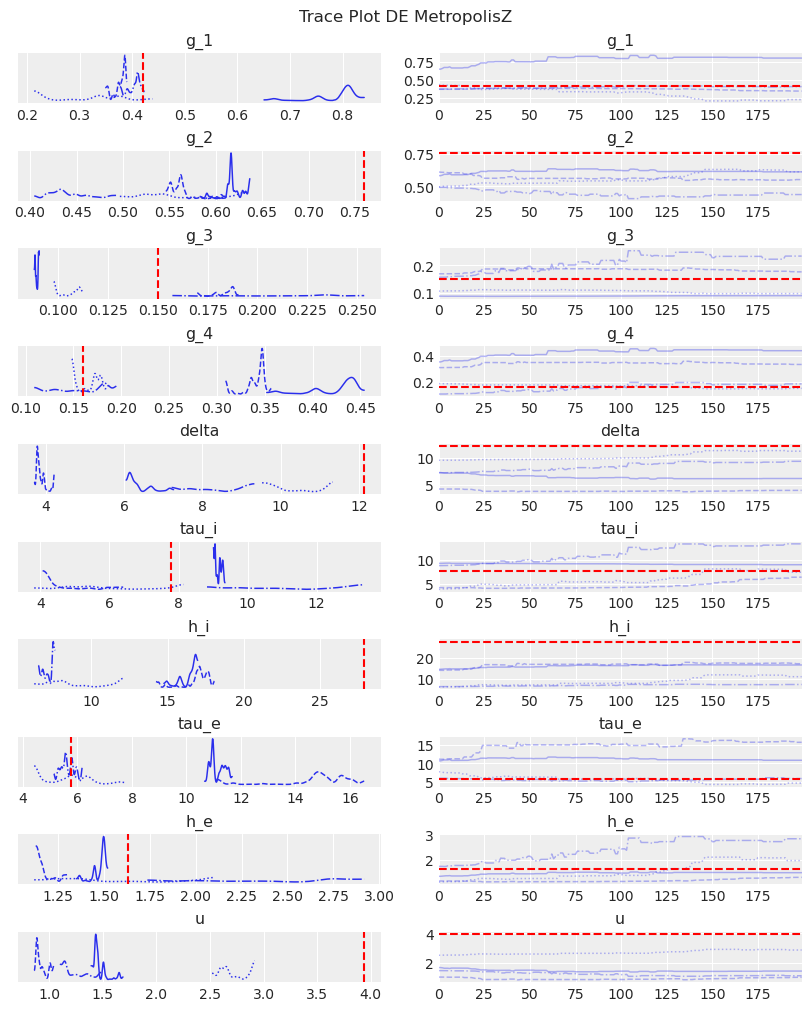

In [61]:
plot_trace(trace, my_var_names, theta_true, sampler);

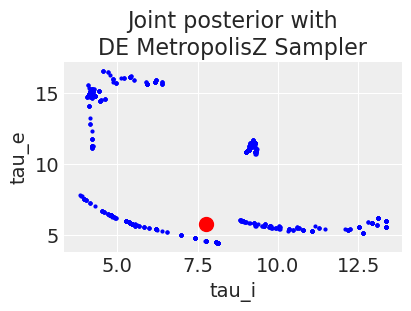

In [62]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

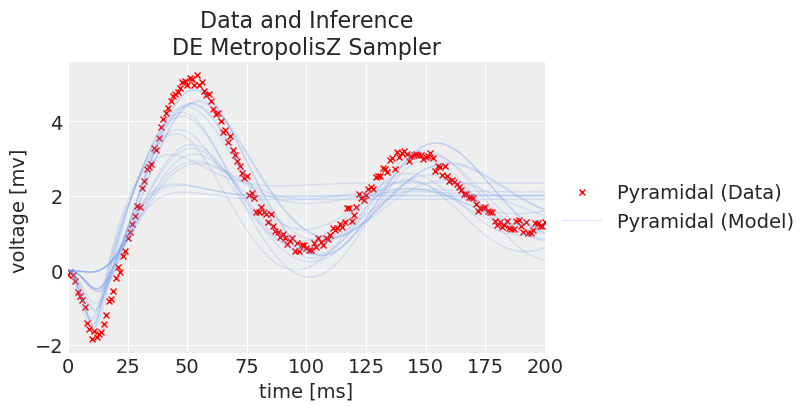

In [63]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference\n{sampler} Sampler")

In [64]:
rmse_fit_DEMZ, rmse_params_DEMZ =rmse_fit(model, trace, data, theta_true )
print ('RMSE to true parameters', rmse_fit_DEMZ),
print ('RMSE to true observation', rmse_params_DEMZ)

RMSE to true parameters 369.0309804869199
RMSE to true observation 59.66447857532787


**Notes:**  
DEMetropolisZ is much quicker than the Slice and Metropolis samplers and therefore had a higher ESS per minute spent sampling.  But there is no convergence hence the estimated parameters and the fit deviates from true values. 

### DEMetropolis Sampler

In these experiments, DEMetropolis sampler was not accepting `tune` and requiring `chains` to be at least 11. We set draws at 5000, lower number like 3000 produce bad mixing. 

In [65]:
sampler = "DEMetropolis"

start_time = time.time()
with model:
    trace_DEM = pm.sample(step=[pm.DEMetropolis(vars_list)],  draws=4000, chains=12,
                          initvals={var_name: tails_5th_percentile[var_name] for var_name in my_var_names}
                         )
crudetime_DEM=time.time() - start_time
print("---running took: %s seconds ---" % crudetime_DEM)

Population sampling (12 chains)
DEMetropolis: [g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:844: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:844: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:844: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:844: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:844: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:844: RuntimeWarning: overfl

---running took: 121.70301365852356 seconds ---


In [66]:
trace = trace_DEM
az.summary(trace)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
delta  12.469  16.563   0.312   66.038      4.775    3.462      12.0   
g_1     0.120   0.115   0.003    0.458      0.033    0.024      12.0   
g_2     0.588   0.752   0.107    2.804      0.217    0.157      12.0   
g_3     0.053   0.069   0.011    0.255      0.020    0.014      12.0   
g_4     0.856   0.356   0.261    1.556      0.102    0.074      12.0   
h_e     4.147   2.641   0.494   10.765      0.760    0.551      12.0   
h_i    21.956  18.051   1.557   68.912      5.189    3.769      12.0   
tau_e   8.960   4.085   2.437   17.686      1.177    0.854      12.0   
tau_i   7.756   2.139   3.385   12.599      0.617    0.447      12.0   
u       8.830   6.609   0.562   23.716      1.898    1.376      12.0   

       ess_tail  r_hat  
delta      12.0  14.74  
g_1        12.0   6.34  
g_2        13.0   7.40  
g_3        12.0   8.97  
g_4        12.0   7.06  
h_e        12.0   8.82  
h_i        14.0   6.26  
tau_e      12.0  15.96  
tau_i      12.0   8.42  
u          12.0   6.74

/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no 

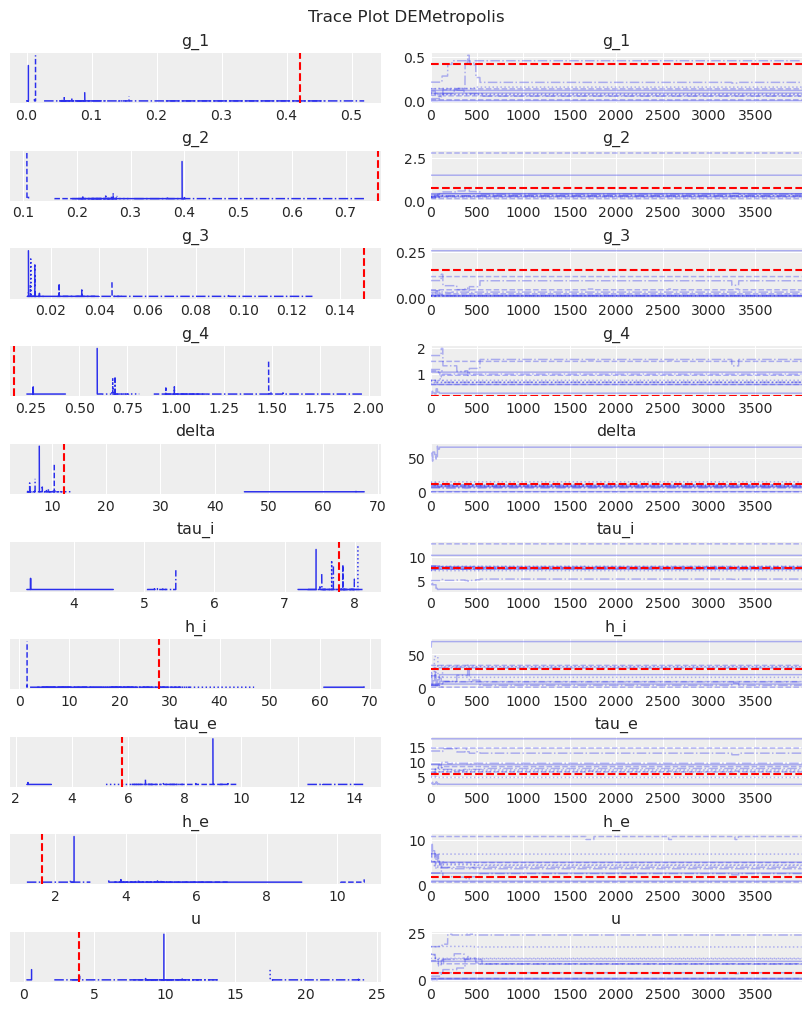

In [67]:
plot_trace(trace, my_var_names, theta_true, sampler);

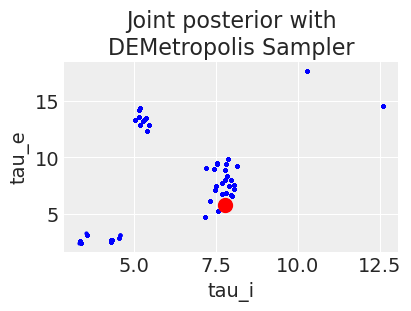

In [68]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

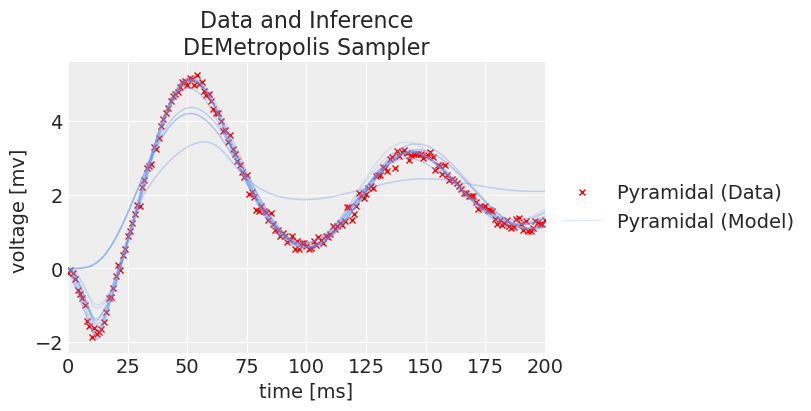

In [69]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference\n{sampler} Sampler")

In [70]:
rmse_params_DEM, rmse_fit_DEM =rmse_fit(model, trace, data, theta_true )
print ('RMSE to true parameters', rmse_params_DEM),
print ('RMSE to true observation', rmse_fit_DEM)

RMSE to true parameters 26.362526056302983
RMSE to true observation 36799.259611995454


**Notes:**  
Despite the high number of EES by fast sampling over large iterations, this is also not an appropriate samlper for our model.

### SMC Sampler

The Sequential Monte Carlo (SMC) sampler can be used to sample a regular Bayesian model or to run model without a likelihood (Aproximate Bayesian Computation). Let's try first with a regular model,

#### SMC with a Likelihood Function

SMC has no initialized strategy!

In [71]:
sampler = "SMC with Likelihood"

start_time = time.time()
with model:
    trace_SMC_like = pm.sample_smc(draws=draws, chains=n_chains)
crudetime_SMC_like=time.time() - start_time
print("---running took: %s seconds ---" % crudetime_SMC_like)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


---running took: 14.434098482131958 seconds ---.00% [100/100 00:00<?  Stage: 11 Beta: 1.000]


In [72]:
trace = trace_SMC_like
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
delta  12.798  0.389  12.072   13.532      0.014    0.010     759.0     760.0   
g_1     0.531  0.117   0.320    0.756      0.004    0.003     835.0     815.0   
g_2     0.666  0.073   0.519    0.788      0.003    0.002     755.0     858.0   
g_3     0.147  0.021   0.108    0.189      0.001    0.001     668.0     802.0   
g_4     0.211  0.033   0.149    0.268      0.001    0.001     735.0     784.0   
h_e     1.924  0.210   1.522    2.311      0.007    0.005     767.0     813.0   
h_i    19.216  3.205  13.591   25.155      0.115    0.082     758.0     737.0   
tau_e   5.522  0.156   5.249    5.837      0.006    0.004     746.0     775.0   
tau_i   7.666  0.091   7.506    7.848      0.003    0.002     767.0     736.0   
u       3.084  0.501   2.167    3.984      0.018    0.013     767.0     752.0   

       r_hat  
delta   1.00  
g_1     1.00  
g_2     1.00  
g_3     1.01  
g_4     1.00  
h_e     1.00  
h_i     1.00  
tau_e   1.00  
tau_i   1.01  
u       1.00

In [73]:
trace.sample_stats._t_sampling

14.204116106033325

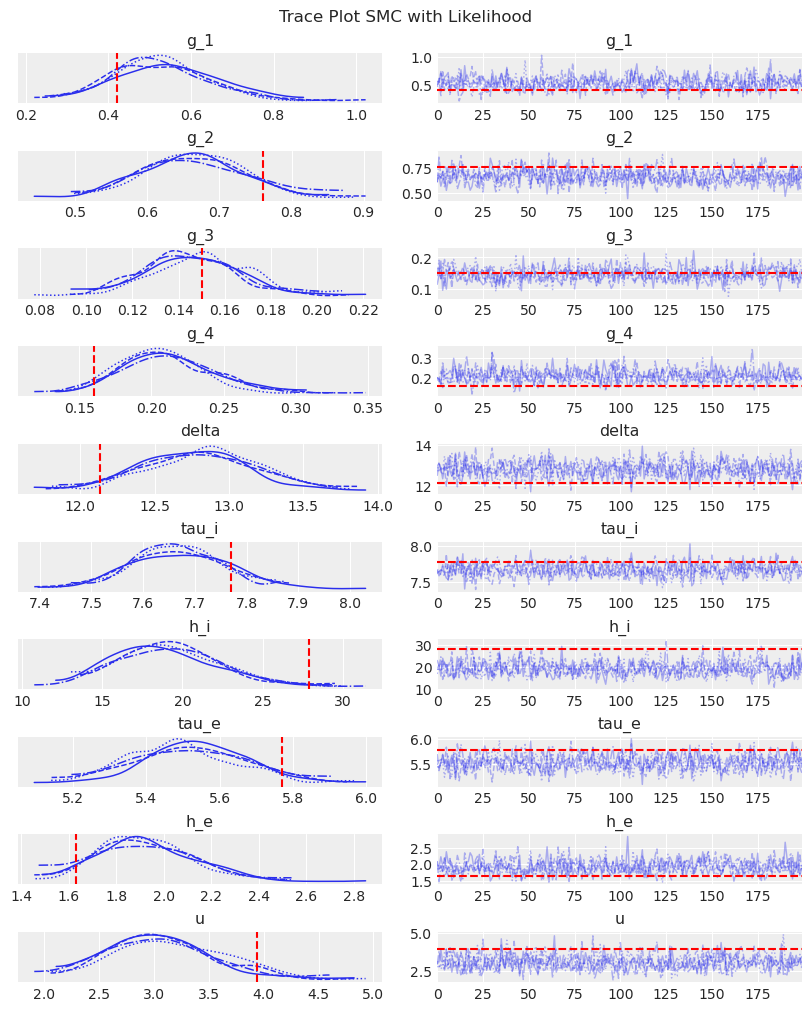

In [74]:
plot_trace(trace, my_var_names, theta_true, sampler);

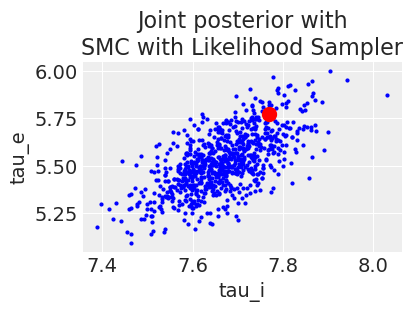

In [75]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

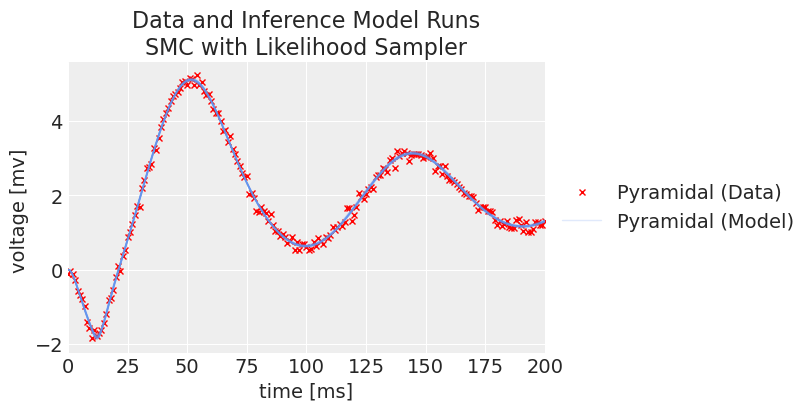

In [76]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [77]:
rmse_fit_SMC_like, rmse_params_SMC_like=rmse_fit(model, trace, data, theta_true )
print ('RMSE to true parameters', rmse_fit_SMC_like),
print ('RMSE to true observation', rmse_params_SMC_like)

RMSE to true parameters 78.06014283447092
RMSE to true observation 3.8708478287824386


**Notes:**  
The SMC algorithm finds different modes, and its convergence is better than previus samplers, but still the fit deviates from the observation.  

#### SMC Using `pm.Simulator` Epsilon=1

As outlined in the SMC tutorial on PyMC.io, the SMC sampler can be used for Aproximate Bayesian Computation, i.e. we can use a `pm.Simulator` instead of a explicit likelihood.  Here is a rewrite of the PyMC - odeint model for SMC-ABC.

The simulator function needs to have the correct signature (e.g., accept an rng argument first).  

In [78]:
def simulator_forward_model(rng,  g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u, size=None):
    theta = g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u 
    mu=odeint(func=DCM_ERPmodel, y0=x_init, t=ts, args=(theta,))[:,8][::ds].reshape(-1, 1)
    return rng.normal(mu, sigma_true)

Here is the model with the simulator function. Instead of a explicit likelihood function, the simulator uses distance metric (defaults to `gaussian`) between the simulated and observed values. When using a simulator we also need to specify epsilon, that is a tolerance value for the discrepancy between simulated and observed values. If epsilon is too low, SMC will not be able to move away from the initial values or a few values. We can easily see this with `az.plot_trace`. If epsilon is too high, the posterior will virtually be the prior. So

In [79]:
with pm.Model() as model:
    # Priors
    g_1 = pm.Gamma("g_1", alpha=prior_specs['shape'][0], beta=prior_specs['rate'][0])
    g_2 = pm.Gamma("g_2", alpha=prior_specs['shape'][1], beta=prior_specs['rate'][1])
    g_3 = pm.Gamma("g_3", alpha=prior_specs['shape'][2], beta=prior_specs['rate'][2])
    g_4 = pm.Gamma("g_4", alpha=prior_specs['shape'][3], beta=prior_specs['rate'][3])
    delta = pm.Gamma("delta", alpha=prior_specs['shape'][4], beta=prior_specs['rate'][4])
    tau_i = pm.Gamma("tau_i", alpha=prior_specs['shape'][5], beta=prior_specs['rate'][5])
    h_i = pm.Gamma("h_i", alpha=prior_specs['shape'][6], beta=prior_specs['rate'][6])
    tau_e = pm.Gamma("tau_e", alpha=prior_specs['shape'][7], beta=prior_specs['rate'][7])
    h_e = pm.Gamma("h_e", alpha=prior_specs['shape'][8], beta=prior_specs['rate'][8])
    u = pm.Gamma("u", alpha=prior_specs['shape'][9], beta=prior_specs['rate'][9])
    
    #sigma = pm.HalfNormal("sigma", 10)
    
    # ode_solution
    pm.Simulator(
        "xpy_obs",
        simulator_forward_model,
        params=(g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u),
        epsilon=1,
        observed=data[["pyramidal"]].values,)

Inference.  Note the `progressbar` was throwing an error so it is turned off.  

In [80]:
sampler = "SMC_epsilon=1"

start_time = time.time()
with model:
    trace_SMC_e1 = pm.sample_smc(draws=draws, progressbar=False, chains=n_chains)
crudetime_SMC_e1=time.time() - start_time
print("---running took: %s seconds ---" % crudetime_SMC_e1)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


---running took: 11.770657539367676 seconds ---


In [81]:
trace = trace_SMC_e1
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
delta  12.361  1.499   9.638   15.150      0.056    0.040     714.0     746.0   
g_1     0.547  0.125   0.313    0.774      0.004    0.003     768.0     758.0   
g_2     0.656  0.082   0.510    0.804      0.003    0.002     611.0     671.0   
g_3     0.145  0.023   0.105    0.188      0.001    0.001     750.0     642.0   
g_4     0.213  0.032   0.153    0.272      0.001    0.001     690.0     715.0   
h_e     1.916  0.235   1.532    2.382      0.009    0.006     705.0     737.0   
h_i    19.174  3.087  13.694   24.998      0.106    0.075     855.0     807.0   
tau_e   5.758  0.617   4.596    6.816      0.023    0.016     733.0     764.0   
tau_i   7.760  0.601   6.712    8.950      0.022    0.016     750.0     685.0   
u       3.103  0.606   2.037    4.215      0.022    0.016     755.0     725.0   

       r_hat  
delta   1.00  
g_1     1.00  
g_2     1.01  
g_3     1.00  
g_4     1.00  
h_e     1.01  
h_i     1.01  
tau_e   1.00  
tau_i   1.00  
u       1.00

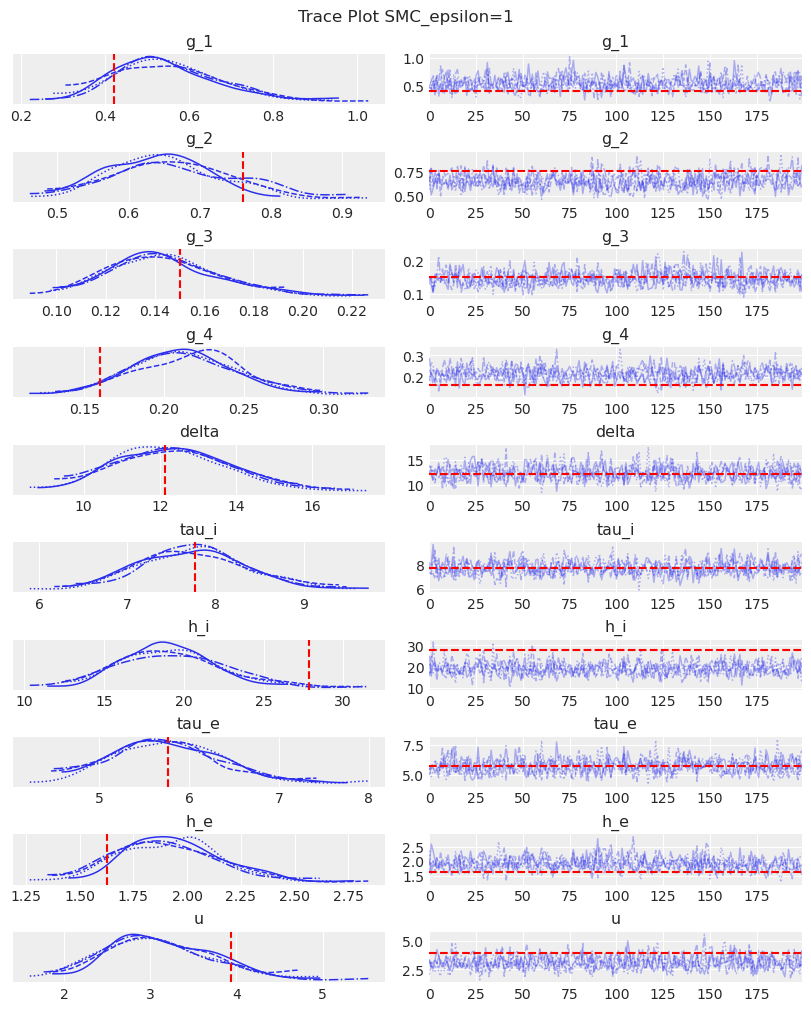

In [82]:
plot_trace(trace, my_var_names, theta_true, sampler);

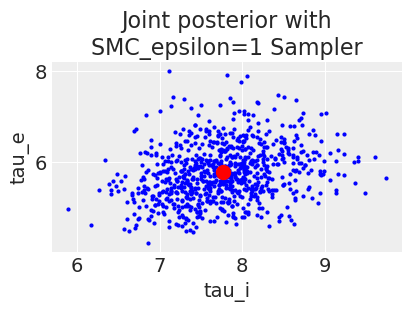

In [83]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

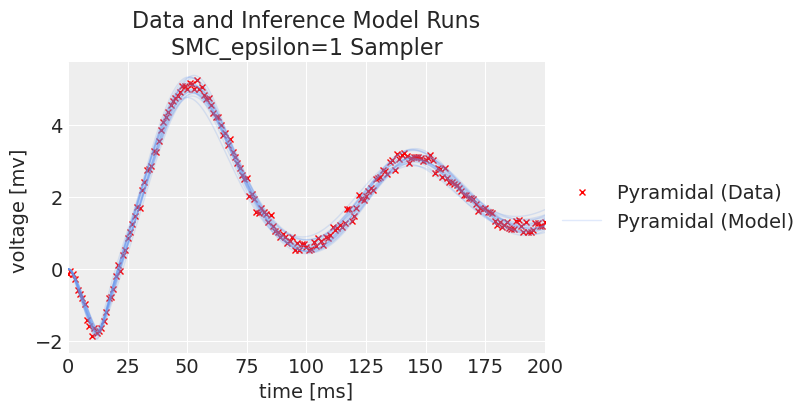

In [84]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [85]:
rmse_params_SMC_e1, rmse_fit_SMC_e1=rmse_fit(model, trace, data, theta_true )
print ('RMSE to true parameters', rmse_params_SMC_e1),
print ('RMSE to true observation', rmse_fit_SMC_e1)

RMSE to true parameters 80.43267893959542
RMSE to true observation 4.7882926328113715


**Notes:**  
Noe we can see that by tunning the Epsilon parameters the chains convrged to same mode, and leads to a decent fit.

In [86]:
with pm.Model() as model:
   # Priors
    g_1 = pm.Gamma("g_1", alpha=prior_specs['shape'][0], beta=prior_specs['rate'][0])
    g_2 = pm.Gamma("g_2", alpha=prior_specs['shape'][1], beta=prior_specs['rate'][1])
    g_3 = pm.Gamma("g_3", alpha=prior_specs['shape'][2], beta=prior_specs['rate'][2])
    g_4 = pm.Gamma("g_4", alpha=prior_specs['shape'][3], beta=prior_specs['rate'][3])
    delta = pm.Gamma("delta", alpha=prior_specs['shape'][4], beta=prior_specs['rate'][4])
    tau_i = pm.Gamma("tau_i", alpha=prior_specs['shape'][5], beta=prior_specs['rate'][5])
    h_i = pm.Gamma("h_i", alpha=prior_specs['shape'][6], beta=prior_specs['rate'][6])
    tau_e = pm.Gamma("tau_e", alpha=prior_specs['shape'][7], beta=prior_specs['rate'][7])
    h_e = pm.Gamma("h_e", alpha=prior_specs['shape'][8], beta=prior_specs['rate'][8])
    u = pm.Gamma("u", alpha=prior_specs['shape'][9], beta=prior_specs['rate'][9])
    
    #sigma = pm.HalfNormal("sigma", 10)
    
    # ode_solution
    pm.Simulator(
        "xpy_obs",
        simulator_forward_model,
        params=(g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u),
        epsilon=10,
        observed=data[["pyramidal"]].values, )

In [87]:
sampler = "SMC epsilon=10"

start_time = time.time()
with model:
    trace_SMC_e10 = pm.sample_smc(draws=draws, chains=n_chains )
crudetime_SMC_e10=time.time() - start_time
print("---running took: %s seconds ---" % crudetime_SMC_e10)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/data/base.py:265: UserWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


---running took: 4.460295677185059 seconds ---


In [88]:
trace = trace_SMC_e10
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
delta  11.781  2.147   8.365   16.449      0.080    0.057     736.0     728.0   
g_1     0.552  0.131   0.344    0.817      0.005    0.003     800.0     775.0   
g_2     0.622  0.102   0.422    0.802      0.003    0.002     863.0     669.0   
g_3     0.140  0.025   0.097    0.187      0.001    0.001     695.0     662.0   
g_4     0.209  0.038   0.141    0.280      0.001    0.001     814.0     815.0   
h_e     1.722  0.314   1.141    2.298      0.011    0.008     804.0     838.0   
h_i    18.938  3.725  11.992   25.750      0.133    0.094     783.0     775.0   
tau_e   5.444  0.871   3.872    6.984      0.033    0.024     699.0     807.0   
tau_i   7.962  1.211   5.842   10.278      0.043    0.030     805.0     767.0   
u       3.064  0.630   1.874    4.134      0.023    0.016     758.0     795.0   

       r_hat  
delta   1.01  
g_1     1.00  
g_2     1.00  
g_3     1.00  
g_4     1.00  
h_e     1.00  
h_i     1.00  
tau_e   1.00  
tau_i   1.00  
u       1.00

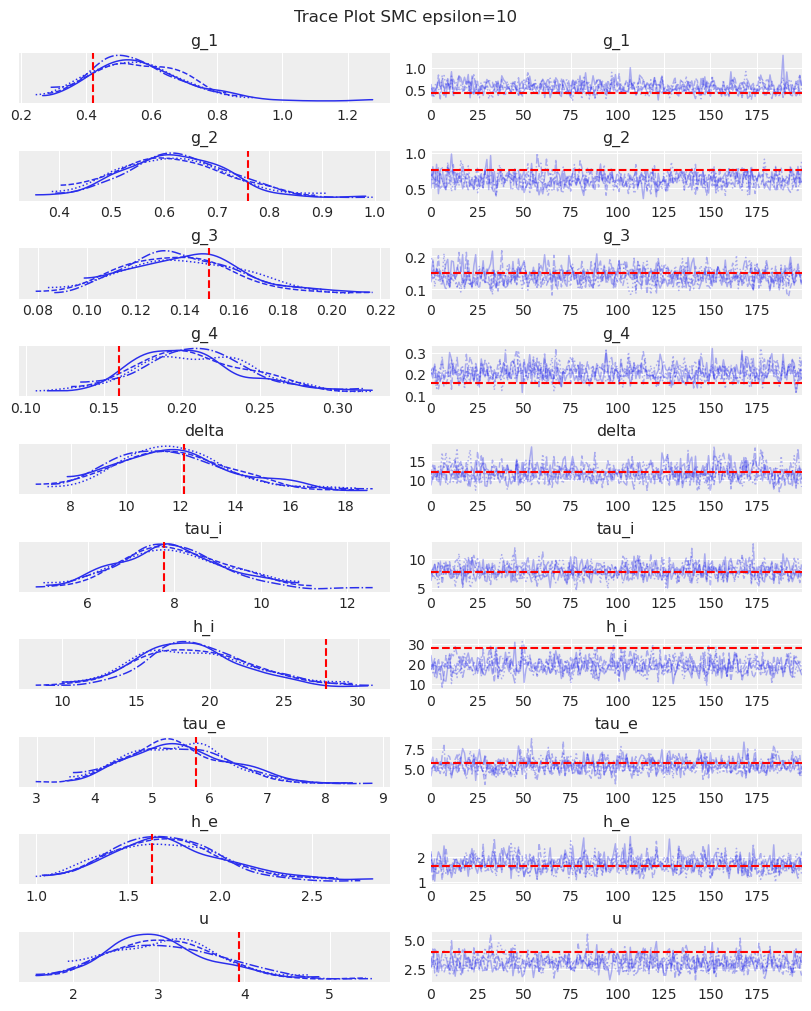

In [89]:
plot_trace(trace, my_var_names, theta_true, sampler);

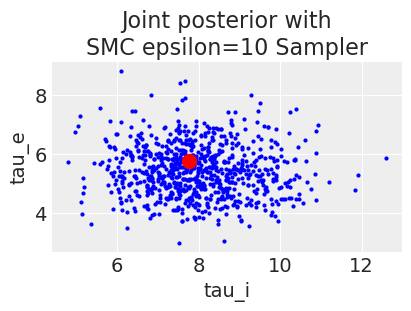

In [90]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

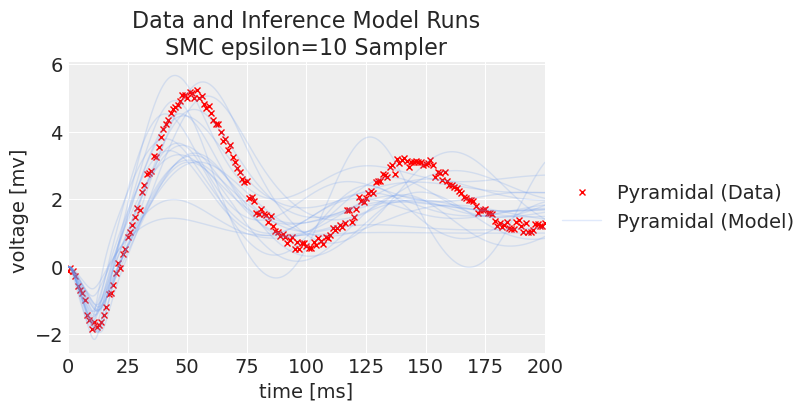

In [91]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [92]:
rmse_params_SMC_e10, rmse_fit_SMC_e10=rmse_fit(model, trace, data, theta_true )
print ('RMSE to true parameters', rmse_params_SMC_e10),
print ('RMSE to true observation', rmse_fit_SMC_e10)

RMSE to true parameters 103.32953047189119
RMSE to true observation 59.51352321346316


**Notes:**  
Now that we set a proper value for epsilon we can see that the SMC sampler (plus simulator) provides good results. Choosing a value for epsilon 
will always involve some trial and error. So, what to do in practice? As epsilon is the scale of the distance function. If you don't have any idea of how much error do you expected to get between simulated and observed values then a rule of thumb for picking an initial guess for epsilon is to use a number smaller than the standard deviation of the observed data, how much smaller maybe one order of magnitude or so.

### Posterior Correlations
As an aside, it is worth pointing out that the posterior parameter space is a difficult geometry for sampling, dur no nonlinear relation betwen parameters (eg banna shape between g_3 and g_4).  

/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/pairplot.py:233: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


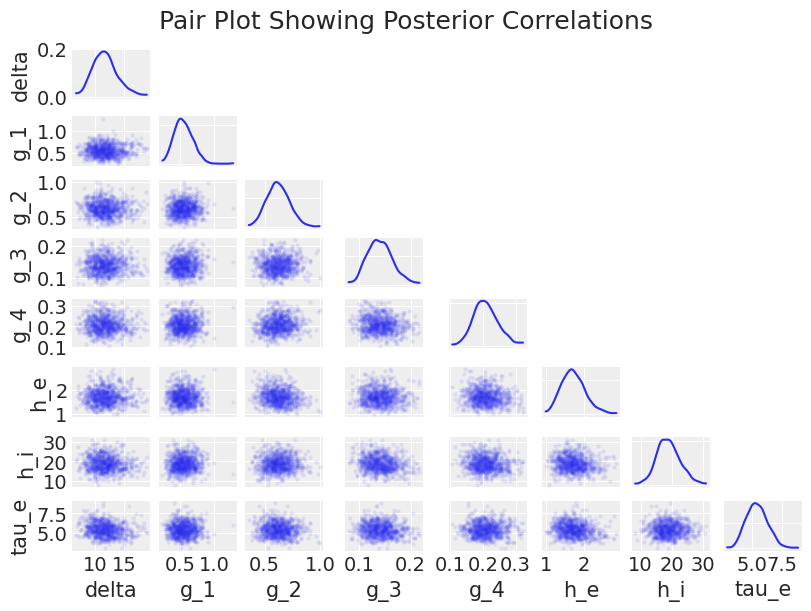

In [93]:
az.plot_pair(trace, figsize=(8, 6), scatter_kwargs=dict(alpha=0.1), marginals=True)
plt.suptitle("Pair Plot Showing Posterior Correlations", size=18);

The major observation here is that the posterior shape is pretty difficult for a sampler to handle, with positive correlations, negative correlations, crecent-shapes, and large variations in scale.  This contributes to the slow sampling (in addition to the computational overhead in solving the ODE thousands of times).  This is also fun to look at for understanding how the model parameters impact each other.       

## Bayesian Inference with Gradients

NUTS, the PyMC default sampler can only be used if gradients are supplied to the sampler.  In this section, we will solve the system of ODEs within PyMC in two different ways that supply the sampler with gradients.  The first is the built-in `pymc.ode.DifferentialEquation` solver, and the second is to forward simulate using `pytensor.scan`, which allows looping.  Note that there may be other better and faster ways to perform Bayesian inference with ODEs using gradients, such as the [sunode](https://sunode.readthedocs.io/en/latest/index.html) project, and [diffrax](https://www.pymc-labs.io/blog-posts/jax-functions-in-pymc-3-quick-examples/), which relies on JAX.

### PyMC ODE Module

`Pymc.ode` uses `scipy.odeint` under the hood to estimate a solution and then estimate the gradient through finite differences. 

The `pymc.ode` API is similar to `scipy.odeint`.  The right-hand-side equations are put in a function and written as if `y` and `p` are vectors, as follows.  (Even when your model has one state and/or one parameter, you should explicitly write `y[0]` and/or `p[0]`.)

In [94]:
# We remove jit to avoid error with Pymc gradient-based samplers
def Sigmodal(x1, x2, delta, c):
    S=(1./(1.+np.exp(c*(x1-(delta*x2)))))-0.5
    return S

In [95]:
def DCM_ERPmodel_pymcode(x, t, p):
    c = constants[0]
    dx0_dt = x[3]
    dx1_dt = x[4]
    dx2_dt = x[5]
    dx3_dt = (1./p[7]) * (p[8] * (p[0] * (Sigmodal(x[8], x[4] - x[5], p[4] , c)) + p[9]) - (x[0] / p[7]) - 2 * x[3])
    dx4_dt = (1./p[7]) * (p[8] * (p[1] * (Sigmodal(x[0], x[3], p[4] , c))) - (x[1] / p[7] ) - 2 * x[4])
    dx5_dt = (1./p[5]) * (p[6] * (p[3] * (Sigmodal(x[6], x[7], p[4] , c))) - (x[2] / p[5] ) - 2 * x[5])
    dx6_dt = x[7]
    dx7_dt = (1./p[7]) * (p[8] * (p[2] * (Sigmodal(x[8], x[4] - x[5], p[4] , c))) - (x[6] / p[7] ) - 2 * x[7])
    dx8_dt = x[4] - x[5]
    return [dx0_dt, dx1_dt, dx2_dt, dx3_dt, dx4_dt, dx5_dt, dx6_dt, dx7_dt, dx8_dt]

`DifferentialEquation` takes as arguments:

* `func`: A function specifying the differential equation (i.e. $f(\mathbf{y},t,\mathbf{p})$),
* `times`: An array of times at which data was observed,
* `n_states`: The dimension of $f(\mathbf{y},t,\mathbf{p})$ (number of output parameters),
* `n_theta`: The dimension of $\mathbf{p}$ (number of input parameters),
* `t0`: Optional time to which the initial condition belongs,  

as follows:

In [96]:
ode_model = DifferentialEquation(
    func=DCM_ERPmodel_pymcode, times=data.ts_obs.values, n_states=9, n_theta=10, t0=data.ts_obs.values[0]
)

Once the ODE is specified, we can use it in our PyMC model.

#### Inference with NUTS
`pymc.ode` is quite slow (an order of hours for just a few samples), so for demonstration purposes, we will only draw a few samples.  

In [97]:
with pm.Model() as model:
    # Priors
    g_1 = pm.Gamma("g_1", alpha=prior_specs['shape'][0], beta=prior_specs['rate'][0])
    g_2 = pm.Gamma("g_2", alpha=prior_specs['shape'][1], beta=prior_specs['rate'][1])
    g_3 = pm.Gamma("g_3", alpha=prior_specs['shape'][2], beta=prior_specs['rate'][2])
    g_4 = pm.Gamma("g_4", alpha=prior_specs['shape'][3], beta=prior_specs['rate'][3])
    delta = pm.Gamma("delta", alpha=prior_specs['shape'][4], beta=prior_specs['rate'][4])
    tau_i = pm.Gamma("tau_i", alpha=prior_specs['shape'][5], beta=prior_specs['rate'][5])
    h_i = pm.Gamma("h_i", alpha=prior_specs['shape'][6], beta=prior_specs['rate'][6])
    tau_e = pm.Gamma("tau_e", alpha=prior_specs['shape'][7], beta=prior_specs['rate'][7])
    h_e = pm.Gamma("h_e", alpha=prior_specs['shape'][8], beta=prior_specs['rate'][8])
    u = pm.Gamma("u", alpha=prior_specs['shape'][9], beta=prior_specs['rate'][9])
    
    params_samples=[g_1, g_2, g_3, g_4, delta, tau_i,  h_i, tau_e, h_e, u]

    # ode_solution
    ode_solution = ode_model(y0=x_init, theta=params_samples)
    
    # Likelihood
    pm.Normal("xpy_obs", mu=ode_solution[:, 8][::ds], sigma=sigma_true, observed=data[["pyramidal"]].values)

In [98]:
sampler = "NUTS PyMC ODE"

start_time = time.time()
with model:
    trace_nuts_pymc_ode = pm.sample(tune=20, draws=20, chains=1,
                                    initvals={var_name: tails_5th_percentile[var_name] for var_name in my_var_names},  
                                    nuts_sampler_kwargs={"nuts": {"max_treedepth": 10, "target_accept": 0.8}}   
                                   )
crudetime_nuts_pymc_ode=time.time() - start_time
print("---running took: %s seconds ---" % crudetime_nuts_pymc_ode)

Only 20 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u]


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+01   r2 =                  NaN


/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+01   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00


/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1000000000000D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.2000000000000D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.2000000000000D+01


Sampling 1 chain for 20 tune and 20 draw iterations (20 + 20 draws total) took 456 seconds.
The number of samples is too small to check convergence reliably.


---running took: 461.1098871231079 seconds ---


In [99]:
trace = trace_nuts_pymc_ode
az.summary(trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 20), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
delta   1.405  0.385   1.168    2.161      0.207    0.161       2.0      20.0   
g_1     0.255  0.001   0.254    0.256      0.000    0.000       2.0      20.0   
g_2     0.516  0.057   0.405    0.564      0.035    0.028       2.0      20.0   
g_3     0.105  0.001   0.103    0.106      0.001    0.001       2.0      20.0   
g_4     0.087  0.001   0.085    0.088      0.001    0.001       2.0      20.0   
h_e     2.806  0.340   2.154    3.099      0.206    0.169       2.0      20.0   
h_i    12.886  0.048  12.802   12.935      0.019    0.014       8.0      20.0   
tau_e   3.157  0.987   2.453    5.097      0.563    0.443       2.0      20.0   
tau_i   7.210  0.054   7.156    7.307      0.023    0.018       7.0      20.0   
u       3.348  0.050   3.268    3.422      0.035    0.029       2.0      20.0   

       r_hat  
delta    NaN  
g_1      NaN  
g_2      NaN  
g_3      NaN  
g_4      NaN  
h_e      NaN  
h_i      NaN  
tau_e    NaN  
tau_i    NaN  
u        NaN

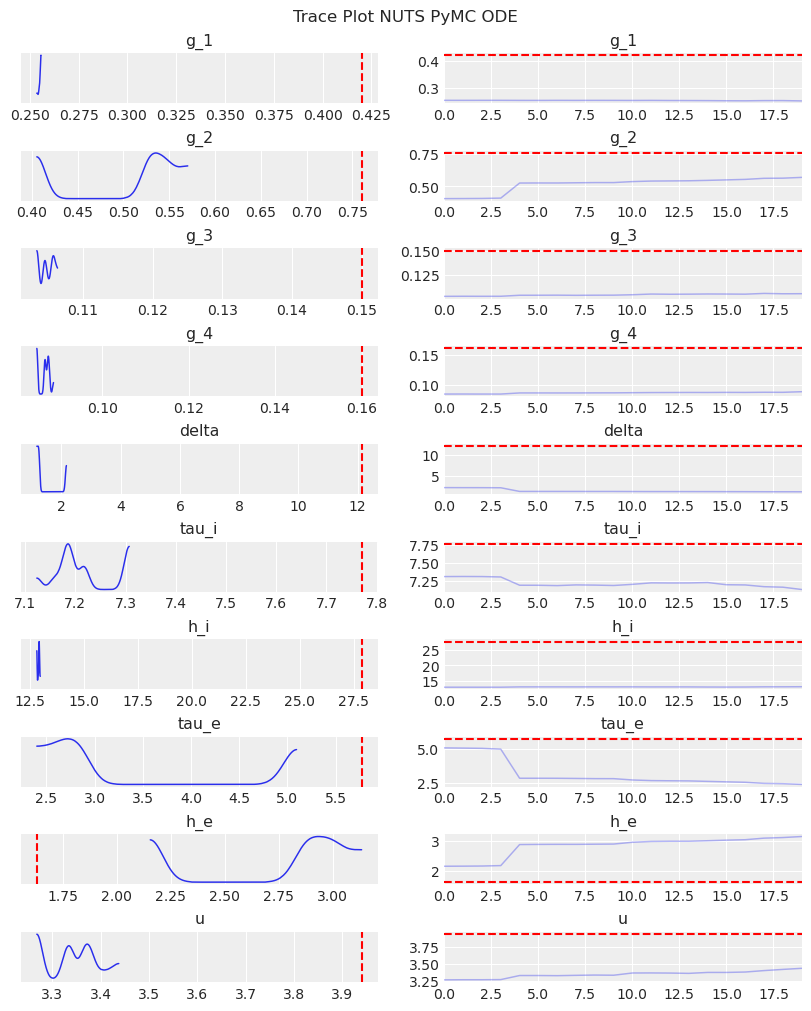

In [100]:
plot_trace(trace, my_var_names, theta_true, sampler);

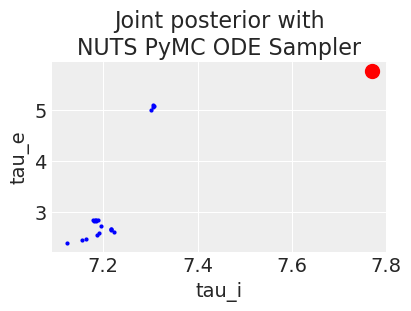

In [101]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

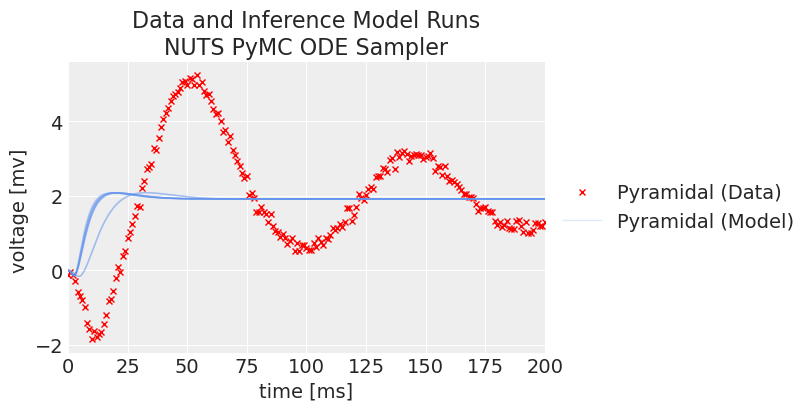

In [102]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [103]:
rmse_params_nuts_pymc_ode, rmse_fit_nuts_pymc_ode=rmse_fit(model, trace, data, theta_true)
print ('RMSE to true parameters', rmse_params_nuts_pymc_ode),
print ('RMSE to true observation', rmse_fit_nuts_pymc_ode)

RMSE to true parameters 830.9759221258615
RMSE to true observation 444.84315594419263


**Notes:**  
This implemenation of NUTS with Pymc ODE module is very very slow.   

### Simulate with Pytensor Scan

Finally, we can write the system of ODEs as a forward simulation solver within PyMC.  The way to write for-loops in PyMC is with `pytensor.scan.`  Gradients are then supplied to the sampler via autodifferentiation.    

First, we should test that the time steps are sufficiently small to get a reasonable estimate.  

#### Check Time Steps

Create a function that accepts different numbers of time steps for testing.  The function also demonstrates how `pytensor.scan` is used.  

In [104]:
dt, n_time

(0.1, 2001)

In [105]:
n_steps=int(n_time)

In [106]:
x_init_float64 = []
for _ in range(n_states):
    x_init_float64.append(np.float64(0.0))

In [107]:
# forward simulation model using scan
def model_scan_simulation(theta):
    # PyMC model
    with pm.Model() as model:
            # Priors (these are static for testing)
            g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u  =theta[0], theta[1], theta[2], theta[3], theta[4], theta[5], theta[6], theta[7], theta[8], theta[9],  

            def ode_update_function(x0, x1, x2, x3, x4, x5, x6, x7, x8, g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u ):
                    dx0=x3
                    dx1=x4
                    dx2=x5
                    dx6=x7
                    dx3=(1./tau_e)*(h_e*(g_1*(Sigmodal(x8, x4-x5, delta, c))+u)-(x0/tau_e)-2*x3)
                    dx4=(1./tau_e)*(h_e*(g_2*(Sigmodal(x0, x3, delta, c)))-(x1/tau_e)-2*x4)
                    dx5=(1./tau_i)*(h_i*(g_4*(Sigmodal(x6, x7, delta, c)))-(x2/tau_i)-2*x5)
                    dx7=(1./tau_e)*(h_e*(g_3*(Sigmodal(x8, x4-x5, delta, c)))-(x6/tau_e)-2*x7)
                    dx8=x4-x5

                    x0_new = x0 + dt * dx0 
                    x1_new = x1 + dt * dx1 
                    x2_new = x2 + dt * dx2 
                    x3_new = x3 + dt * dx3 
                    x4_new = x4 + dt * dx4 
                    x5_new = x5 + dt * dx5 
                    x6_new = x6 + dt * dx6 
                    x7_new = x7 + dt * dx7 
                    x8_new = x8 + dt * dx8 

                    return x0_new, x1_new, x2_new, x3_new, x4_new, x5_new, x6_new, x7_new, x8_new
        
            # Pytensor scan looping function
            result, updates = pytensor.scan(
                fn=ode_update_function,  
                outputs_info=x_init_float64,  
                non_sequences=[g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u ], 
                n_steps=n_steps, )

            # Put the results together and track the result
            pm.Deterministic("result", pm.math.stack([result[8]], axis=1))

    return model

Run the simulation for various time steps and plot the results.   

In [108]:
model_scan_simulation(theta)

result ~ Deterministic(f())

Sampling: []
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


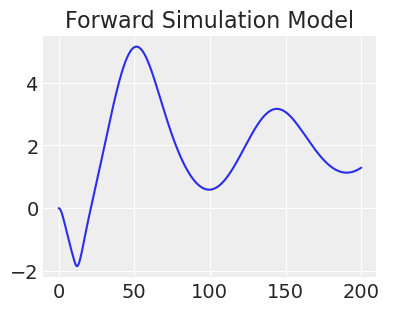

In [109]:
_, ax = plt.subplots(figsize=(4, 3))
model = model_scan_simulation(theta)
with model:
    prior = pm.sample_prior_predictive(1)
    ax.plot(ts, prior.prior.result[0][0].values)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Forward Simulation Model");

#### Inference Using NUTs

In [110]:
def model_scan_inference(theta):

    # PyMC model
    with pm.Model() as model:
        # Priors
        g_1 = pm.Gamma("g_1", alpha=prior_specs['shape'][0], beta=prior_specs['rate'][0])
        g_2 = pm.Gamma("g_2", alpha=prior_specs['shape'][1], beta=prior_specs['rate'][1])
        g_3 = pm.Gamma("g_3", alpha=prior_specs['shape'][2], beta=prior_specs['rate'][2])
        g_4 = pm.Gamma("g_4", alpha=prior_specs['shape'][3], beta=prior_specs['rate'][3])
        delta = pm.Gamma("delta", alpha=prior_specs['shape'][4], beta=prior_specs['rate'][4])
        tau_i = pm.Gamma("tau_i", alpha=prior_specs['shape'][5], beta=prior_specs['rate'][5])
        h_i = pm.Gamma("h_i", alpha=prior_specs['shape'][6], beta=prior_specs['rate'][6])
        tau_e = pm.Gamma("tau_e", alpha=prior_specs['shape'][7], beta=prior_specs['rate'][7])
        h_e = pm.Gamma("h_e", alpha=prior_specs['shape'][8], beta=prior_specs['rate'][8])
        u = pm.Gamma("u", alpha=prior_specs['shape'][9], beta=prior_specs['rate'][9])

        def ode_update_function(x0, x1, x2, x3, x4, x5, x6, x7, x8, g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u ):

                    dx0=x3
                    dx1=x4
                    dx2=x5
                    dx6=x7
                    dx3=(1./tau_e)*(h_e*(g_1*(Sigmodal(x8, x4-x5, delta, c))+u)-(x0/tau_e)-2*x3)
                    dx4=(1./tau_e)*(h_e*(g_2*(Sigmodal(x0, x3, delta, c)))-(x1/tau_e)-2*x4)
                    dx5=(1./tau_i)*(h_i*(g_4*(Sigmodal(x6, x7, delta, c)))-(x2/tau_i)-2*x5)
                    dx7=(1./tau_e)*(h_e*(g_3*(Sigmodal(x8, x4-x5, delta, c)))-(x6/tau_e)-2*x7)
                    dx8=x4-x5

                    x0_new = x0 + dt * dx0 
                    x1_new = x1 + dt * dx1 
                    x2_new = x2 + dt * dx2 
                    x3_new = x3 + dt * dx3 
                    x4_new = x4 + dt * dx4 
                    x5_new = x5 + dt * dx5 
                    x6_new = x6 + dt * dx6 
                    x7_new = x7 + dt * dx7 
                    x8_new = x8 + dt * dx8 

                    return x0_new, x1_new, x2_new, x3_new, x4_new, x5_new, x6_new, x7_new, x8_new
                
                
        result, updates = pytensor.scan(
                fn=ode_update_function,  
                outputs_info=x_init_float64,  
                non_sequences=[g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u ],  
                n_steps=n_steps, )

        final_result = pm.math.stack([result[8]], axis=1)
        
        xpy_hat=final_result[::ds]

        # Likelihood function
        pm.Normal("xpy_obs", mu=xpy_hat, sigma=sigma_true, observed=data[["pyramidal"]].values)
    return model

### NUTS Pytensor Scan Pymc

This is also quite slow, so we will just pull a few samples for demonstration purposes.  

In [111]:
model = model_scan_inference(theta)
sampler = "NUTS Pytensor Scan Pymc"

start_time = time.time()
with model:
    trace_nuts_pytensor_scan_pymc = pm.sample(tune=20, draws=20,  chains=1,
                                            initvals={var_name: tails_5th_percentile[var_name] for var_name in my_var_names},   
                                            nuts_sampler_kwargs={"nuts": {"max_treedepth": 10, "target_accept": 0.8}}
                                             ) 
crudetime_nuts_pytensor_scan_pymc=time.time() - start_time
print("---running took: %s seconds ---" %     crudetime_nuts_pytensor_scan_pymc)

Only 20 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u]


Sampling 1 chain for 20 tune and 20 draw iterations (20 + 20 draws total) took 39 seconds.
The number of samples is too small to check convergence reliably.


---running took: 63.11259484291077 seconds ---


In [112]:
trace = trace_nuts_pytensor_scan_pymc
az.summary(trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 20), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
delta   5.916  2.788   3.534    9.291      1.932    1.623       2.0      20.0   
g_1     0.465  0.007   0.458    0.476      0.004    0.004       3.0      20.0   
g_2     0.935  0.053   0.869    0.990      0.034    0.028       3.0      26.0   
g_3     0.168  0.015   0.145    0.185      0.010    0.009       2.0      20.0   
g_4     0.277  0.016   0.247    0.294      0.011    0.009       3.0      20.0   
h_e     0.997  0.078   0.851    1.072      0.051    0.042       3.0      20.0   
h_i    20.498  1.735  17.761   22.458      1.196    1.005       3.0      20.0   
tau_e  10.694  1.538   8.848   12.098      1.052    0.879       3.0      26.0   
tau_i   9.332  3.251   5.384   12.170      2.267    1.927       2.0      26.0   
u       3.990  0.125   3.865    4.155      0.086    0.072       2.0      26.0   

       r_hat  
delta    NaN  
g_1      NaN  
g_2      NaN  
g_3      NaN  
g_4      NaN  
h_e      NaN  
h_i      NaN  
tau_e    NaN  
tau_i    NaN  
u        NaN

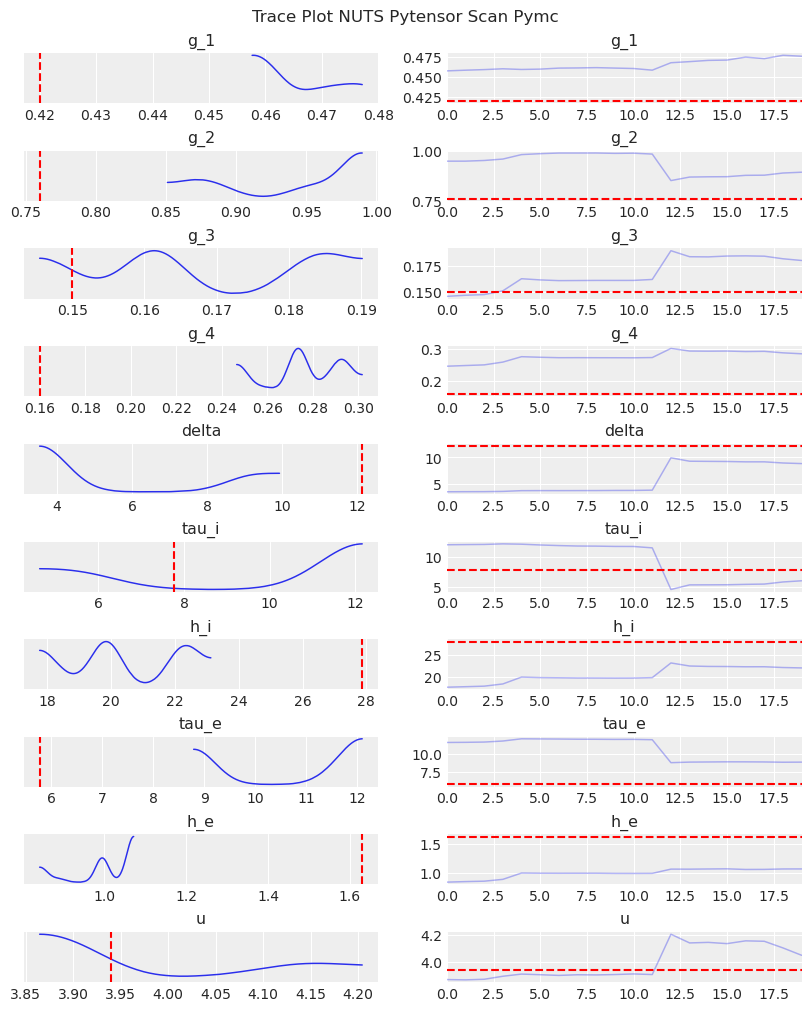

In [113]:
plot_trace(trace, my_var_names, theta_true, sampler);

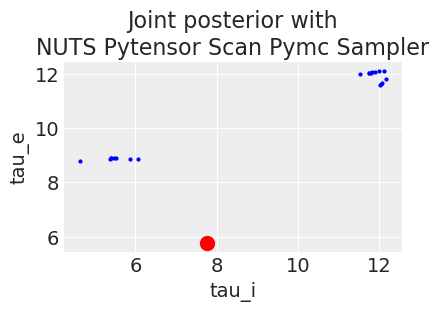

In [114]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

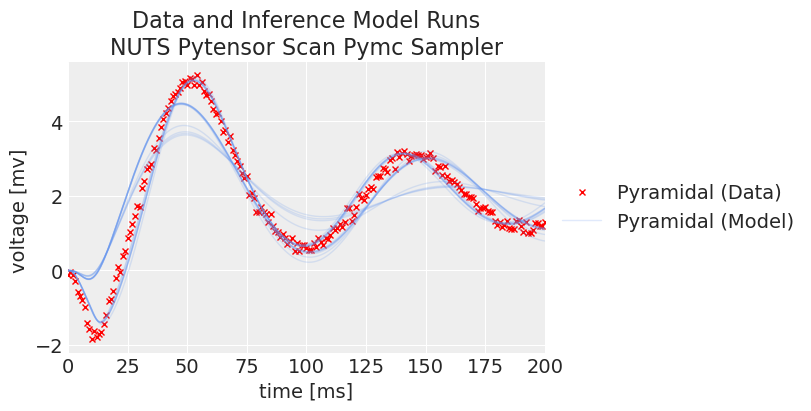

In [115]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [116]:
rmse_params_nuts_pytensor_scan_pymc, rmse_fit_nuts_pytensor_scan_pymc =rmse_fit(model, trace, data, theta_true)
print ('RMSE to true parameters', rmse_params_nuts_pytensor_scan_pymc),
print ('RMSE to true observation', rmse_fit_nuts_pytensor_scan_pymc)

RMSE to true parameters 53.71365744375538
RMSE to true observation 28.131355295696345


**Notes:**  
Still implemenation of NUTS with Pytensor scan is very slow, but at least we get converhgence and a decent fit.   

### NUTS Pytensor Scan Nutpie

In [117]:
model = model_scan_inference(theta)
sampler = "NUTS Pytensor Scan Nutpie"

start_time = time.time()
with model:
    trace_nuts_pytensor_scan_nutpie = pm.sample(nuts_sampler="nutpie", tune=tune, draws=draws, chains=n_chains,
                                                initvals={var_name: tails_5th_percentile[var_name] for var_name in my_var_names},     
                                               )                                             
crudetime_nuts_pytensor_scan_nutpie =time.time() - start_time
print("---running took: %s seconds ---" % crudetime_nuts_pytensor_scan_nutpie)


/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/sampling/mcmc.py:284: UserWarning: `initvals` are currently not passed to nutpie sampler. Use `init_mean` kwarg following nutpie specification instead.
  warnings.warn(


---running took: 3081.2401127815247 seconds ---


In [118]:
trace = trace_nuts_pytensor_scan_nutpie
az.summary(trace)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
delta         6.867   4.653   2.328   15.925      2.260    1.723       4.0   
delta_log__   1.688   0.699   0.845    2.768      0.342    0.261       4.0   
g_1           3.979   4.172   0.011   10.810      2.044    1.560       5.0   
g_1_log__     0.451   1.730  -3.413    2.391      0.818    0.621       5.0   
g_2           2.474   2.451   0.468    6.626      1.200    0.917       5.0   
g_2_log__     0.421   0.976  -0.758    1.891      0.474    0.364       5.0   
g_3           0.149   0.051   0.081    0.212      0.024    0.018       5.0   
g_3_log__    -1.972   0.372  -2.507   -1.553      0.177    0.135       5.0   
g_4           0.235   0.102   0.085    0.339      0.049    0.038       5.0   
g_4_log__    -1.577   0.549  -2.458   -1.079      0.267    0.204       5.0   
h_e           4.387   2.455   1.304    7.547      1.202    0.918       4.0   
h_e_log__     1.274   0.686   0.267    2.021      0.336    0.256       4.0   
h_i          23.732  19.457   4.032   57.076      9.503    7.257       5.0   
h_i_log__     2.785   0.930   1.411    4.050      0.454    0.346       5.0   
tau_e         1.725   2.001   0.154    5.641      0.973    0.742       5.0   
tau_e_log__  -0.228   1.304  -1.868    1.730      0.638    0.487       5.0   
tau_i         8.868   8.276   0.649   22.598      4.054    3.096       5.0   
tau_i_log__   1.565   1.285  -0.432    3.118      0.630    0.481       5.0   
u             6.158   6.969   0.245   18.137      3.407    2.606       5.0   
u_log__       1.132   1.278  -1.407    2.898      0.588    0.468       5.0   

             ess_tail  r_hat  
delta            12.0   3.78  
delta_log__      12.0   3.78  
g_1              11.0   3.37  
g_1_log__        11.0   3.37  
g_2              26.0   2.93  
g_2_log__        26.0   2.60  
g_3              12.0   3.14  
g_3_log__        12.0   3.14  
g_4              11.0   3.33  
g_4_log__        11.0   3.33  
h_e              12.0   3.82  
h_e_log__        12.0   3.82  
h_i              18.0   3.06  
h_i_log__        18.0   3.00  
tau_e            17.0   3.40  
tau_e_log__      17.0   3.37  
tau_i            16.0   3.21  
tau_i_log__      16.0   3.21  
u                12.0   3.07  
u_log__          12.0   2.42

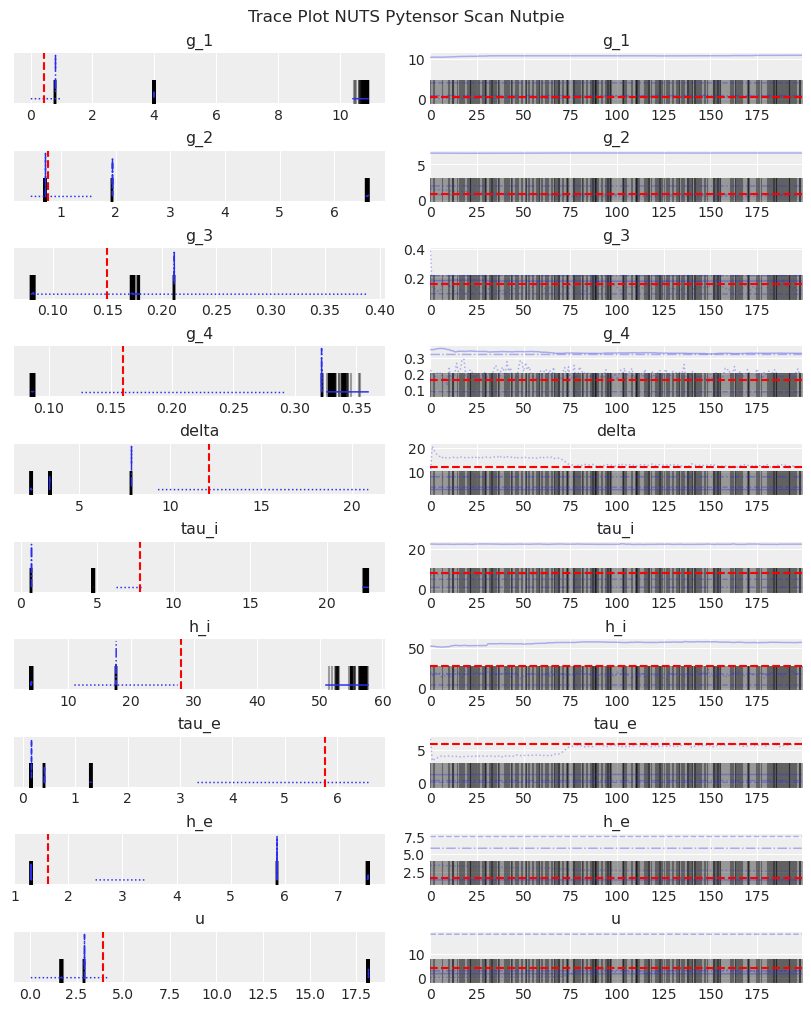

In [119]:
plot_trace(trace, my_var_names, theta_true, sampler);

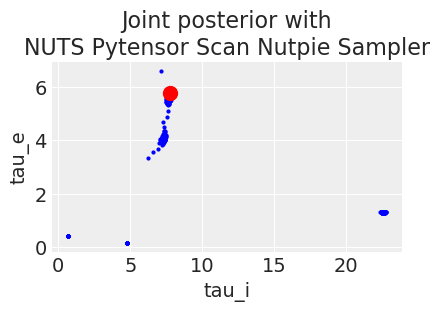

In [120]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

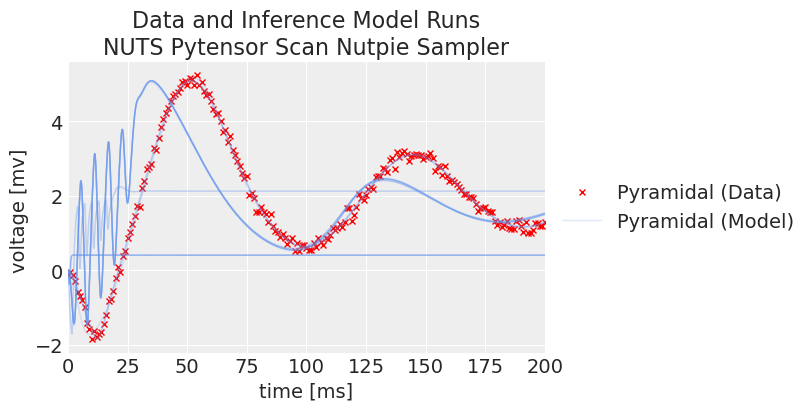

In [121]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [122]:
rmse_params_nuts_pytensor_scan_nutpie, rmse_fit_nuts_pytensor_scan_nutpie=rmse_fit(model, trace, data, theta_true)
print ('RMSE to true parameters', rmse_params_nuts_pytensor_scan_nutpie),
print ('RMSE to true observation', rmse_fit_nuts_pytensor_scan_nutpie)

RMSE to true parameters 4.111607026224847
RMSE to true observation 4426.796201705806


Still implemenation of NUTS with nutpie is also very slow.

### NUTS Pytensor Scan blackjax

In [123]:
model = model_scan_inference(theta)
sampler = "NUTS Pytensor Scan Balckjax"

start_time = time.time()
with model:
    trace_nuts_pytensor_scan_blackjax = pm.sample(nuts_sampler="blackjax", tune=tune, draws=draws, chains=n_chains,  progressbar=False,
                                            initvals={var_name: tails_5th_percentile[var_name] for var_name in my_var_names},
                                            target_accept = 0.8,
                                            nuts = {"max_treedepth": 10},)
crudetime_nuts_pytensor_scan_blackjax =time.time() - start_time
print("---running took: %s seconds ---" % crudetime_nuts_pytensor_scan_blackjax)

/home/meysam/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


---running took: 90.94113230705261 seconds ---


In [124]:
trace = trace_nuts_pytensor_scan_blackjax
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
delta  12.660  0.373  11.993   13.361      0.017    0.012     495.0     470.0   
g_1     0.532  0.126   0.322    0.770      0.004    0.003     907.0     483.0   
g_2     0.654  0.071   0.522    0.789      0.003    0.002     530.0     535.0   
g_3     0.148  0.022   0.105    0.189      0.001    0.001     723.0     614.0   
g_4     0.209  0.033   0.156    0.276      0.001    0.001     571.0     426.0   
h_e     1.938  0.213   1.533    2.304      0.010    0.007     503.0     465.0   
h_i    18.925  3.176  13.297   25.256      0.124    0.091     667.0     411.0   
tau_e   5.600  0.150   5.323    5.877      0.007    0.005     500.0     455.0   
tau_i   7.681  0.090   7.515    7.858      0.004    0.003     640.0     621.0   
u       3.094  0.535   2.174    4.094      0.020    0.014     700.0     538.0   

       r_hat  
delta   1.01  
g_1     1.01  
g_2     1.01  
g_3     1.00  
g_4     1.00  
h_e     1.01  
h_i     1.00  
tau_e   1.01  
tau_i   1.01  
u       1.01

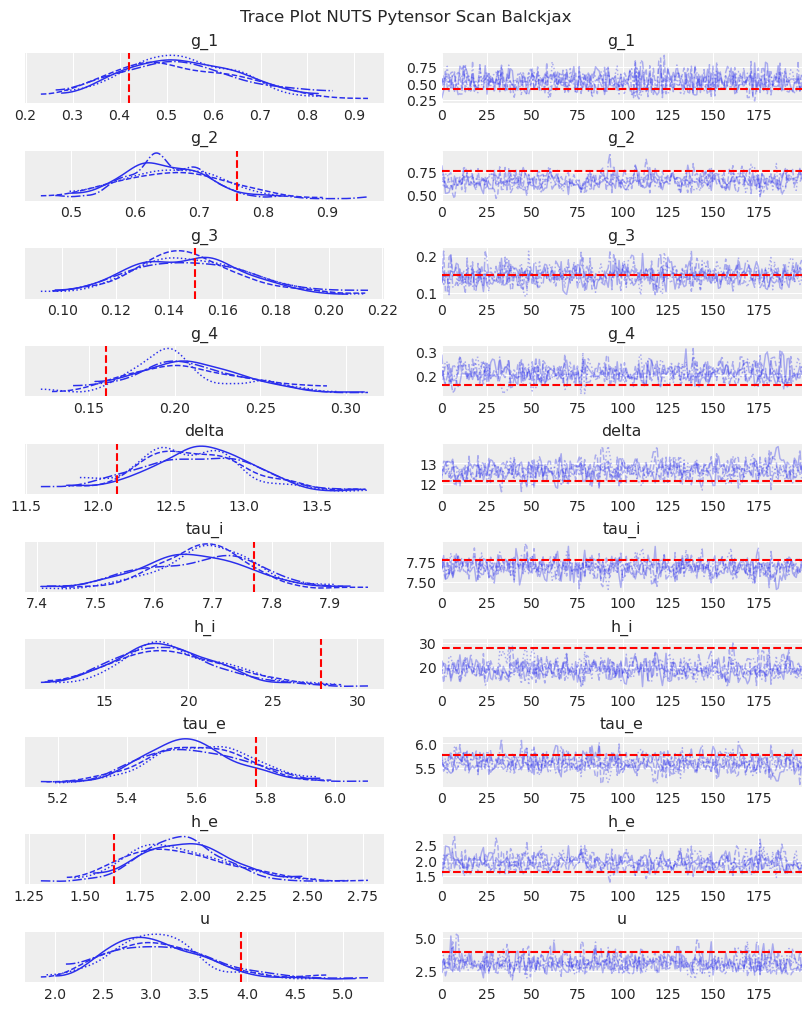

In [125]:
plot_trace(trace, my_var_names, theta_true, sampler);

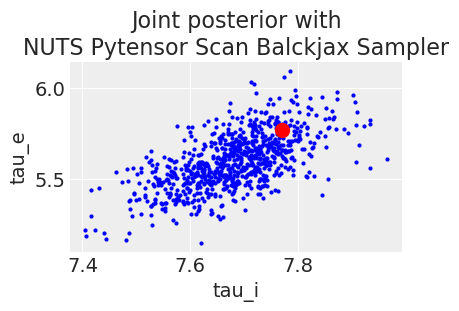

In [126]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

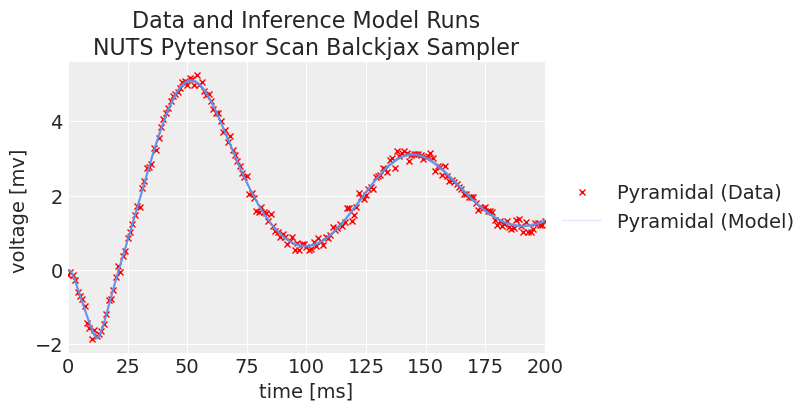

In [127]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [128]:
rmse_params_nuts_pytensor_scan_blackjax, rmse_fit_nuts_pytensor_scan_blackjax=rmse_fit(model, trace, data, theta_true)
print ('RMSE to true parameters', rmse_params_nuts_pytensor_scan_blackjax),
print ('RMSE to true observation', rmse_fit_nuts_pytensor_scan_blackjax),

RMSE to true parameters 83.91199057037699
RMSE to true observation 3.484227105543788


(None,)

**Notes:**  
This implemenation of NUTS with blackjax is very very fast, and we got the convergence, and a perfect fit.   

### NUTS Pytensor Scan Numpyro

In [129]:
model = model_scan_inference(theta)
sampler = "NUTS Pytensor Scan Numpyro"

start_time = time.time()

with model:
    trace_nuts_pytensor_scan_numpyro = pm.sample(nuts_sampler="numpyro", tune=tune, draws=draws, chains=n_chains,  
                                                initvals={var_name: tails_5th_percentile[var_name] for var_name in my_var_names}, 
                                                target_accept = 0.8,
                                                nuts = {"max_treedepth": 10},)
crudetime_nuts_pytensor_scan_numpyro =time.time() - start_time
print("---running took: %s seconds ---" % crudetime_nuts_pytensor_scan_numpyro)

Compiling.. :   0%|                                     | 0/400 [00:00<?, ?it/s]

  0%|                                                   | 0/400 [00:00<?, ?it/s]

Compiling.. :   0%|                                     | 0/400 [00:00<?, ?it/s]


  0%|                                                   | 0/400 [00:00<?, ?it/s]


Compiling.. :   0%|                                     | 0/400 [00:00<?, ?it/s]


Running chain 3:   0%|                                  | 0/400 [00:04<?, ?it/s]

Running chain 0:   0%|                                  | 0/400 [00:04<?, ?it/s]

Running chain 2:  15%|███▌                    | 60/400 [00:05<00:00, 363.56it/s]


Running chain 0:  20%|█████                    | 80/400 [00:06<00:06, 51.59it/s]


Running chain 3:  10%|██▌                      | 40/400 [00:07<00:32, 11.22it/s]

Running chain 0:  25%|██████                  | 100/400 [00:09<00:19, 15.72it/s]

Running chain 2:  30%|███████▏                | 120/400 [00:11<00:21, 13.28it/s]


Running ch

---running took: 94.64155101776123 seconds ---


In [130]:
trace.sample_stats.tree_depth.max().values

array(10)

In [131]:
trace.sample_stats.acceptance_rate.mean().values

array(0.93297356)

In [132]:
trace = trace_nuts_pytensor_scan_numpyro
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
delta  12.654  0.376  11.962   13.387      0.018    0.013     451.0     480.0   
g_1     0.535  0.135   0.305    0.806      0.005    0.003     819.0     450.0   
g_2     0.658  0.074   0.529    0.802      0.003    0.002     573.0     544.0   
g_3     0.150  0.025   0.111    0.201      0.001    0.001     604.0     504.0   
g_4     0.211  0.033   0.152    0.273      0.001    0.001     512.0     556.0   
h_e     1.929  0.219   1.546    2.349      0.009    0.007     547.0     428.0   
h_i    18.659  3.265  13.067   24.924      0.126    0.091     675.0     514.0   
tau_e   5.599  0.151   5.344    5.915      0.007    0.005     463.0     544.0   
tau_i   7.685  0.091   7.514    7.853      0.004    0.003     563.0     574.0   
u       3.089  0.552   2.165    4.162      0.019    0.014     851.0     456.0   

       r_hat  
delta   1.01  
g_1     1.00  
g_2     1.02  
g_3     1.01  
g_4     1.02  
h_e     1.01  
h_i     1.00  
tau_e   1.01  
tau_i   1.01  
u       1.00

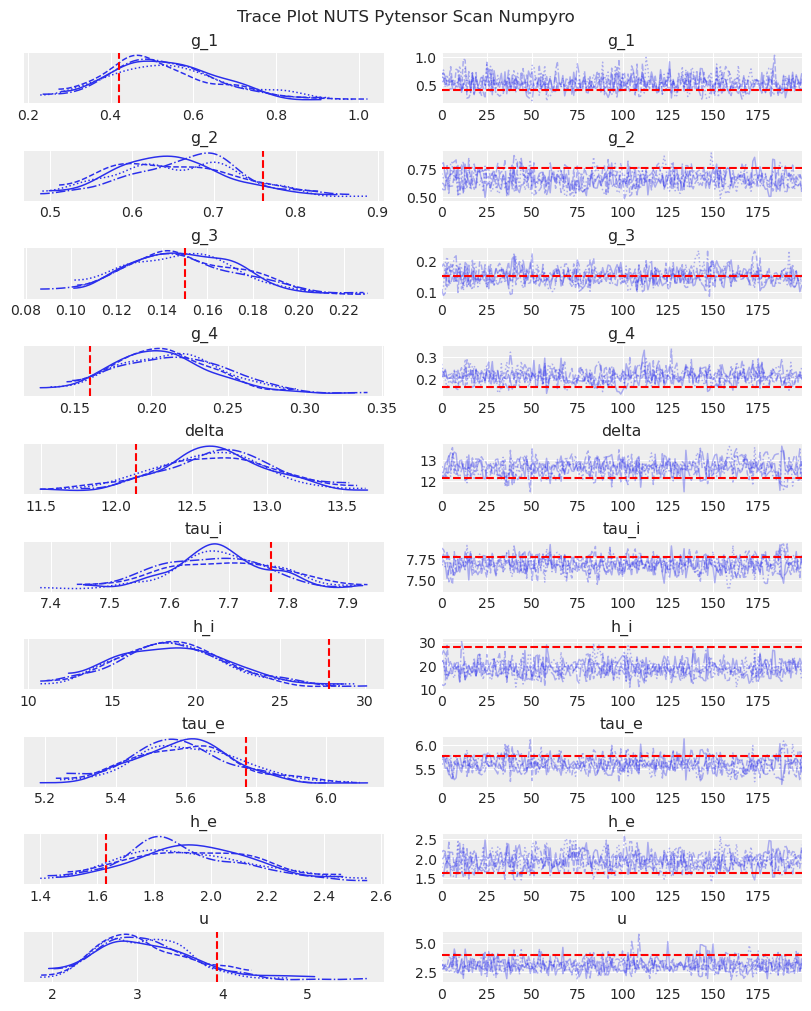

In [133]:
plot_trace(trace, my_var_names, theta_true, sampler);

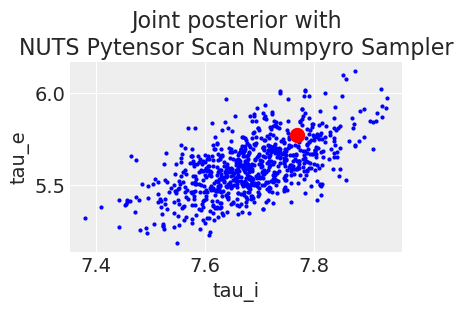

In [134]:
_, ax = plt.subplots(figsize=(4, 3))
plot_joint_post(ax, trace, my_var_names[5], my_var_names[7], my_var_names, theta_true, alpha=1, lw=3,title=f"Joint posterior with\n{sampler} Sampler");

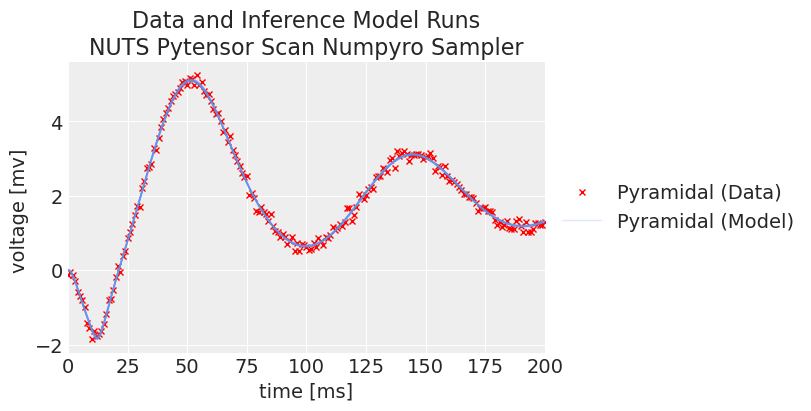

In [135]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

In [136]:
rmse_params_nuts_pytensor_scan_numpyro, rmse_fit_nuts_pytensor_scan_numpyro=rmse_fit(model, trace, data, theta_true)
print ('RMSE to true parameters', rmse_params_nuts_pytensor_scan_numpyro),
print ('RMSE to true observation', rmse_fit_nuts_pytensor_scan_numpyro)

RMSE to true parameters 88.94749931535331
RMSE to true observation 3.8642755058705354


***Notes:*** 

Note that using JIT, such as JAX's JIT, in NumPyro will provide a much faster sampler (at least an order of magnitude faster) since we can also make the model simuations much faster.

## Summary

Let's compare inference results among these different methods.  Recall that, in order to run this notebook in a reasonable amount of time, we have an insufficient number of samples for many inference methods.  For a fair comparison, we would need to bump up the number of samples and run the notebook for longer.  In sum, we have seen better convergence for gradient-based samplers compared to gradient free, and NUTS with blackjax/numpyro was winner by speed and convergence.    

In [137]:
theta_true = np.array([0.42, 0.76, 0.15, 0.16, 12.13, 5.77, 27.87, 7.77, 1.63, 3.94])

In [138]:
model_names = [
    "Slice Sampler",
    "Metropolis",
    "DE MetropolisZ",
    "DE Metropolis",
    "SMC Likelihood",
    "SMC e=1",
    "SMC e=10",
    "NUTS PyMC ODE",
    "NUTS Pytensor",
    "NUTS Nutpie",
    "NUTS Blackjax",
    "NUTS Numpyro",
]

In [139]:
inference_results = [
    trace_slice,
    trace_M,
    trace_DEMZ,
    trace_DEM,
    trace_SMC_like,
    trace_SMC_e1,
    trace_SMC_e10,
    trace_nuts_pymc_ode,
    trace_nuts_pytensor_scan_pymc,
    trace_nuts_pytensor_scan_nutpie,
    trace_nuts_pytensor_scan_blackjax,
    trace_nuts_pytensor_scan_numpyro,
]

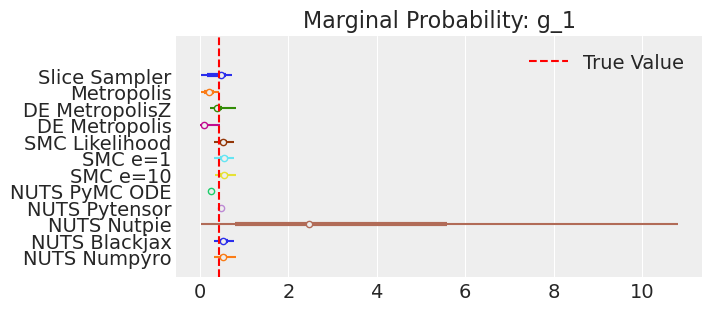

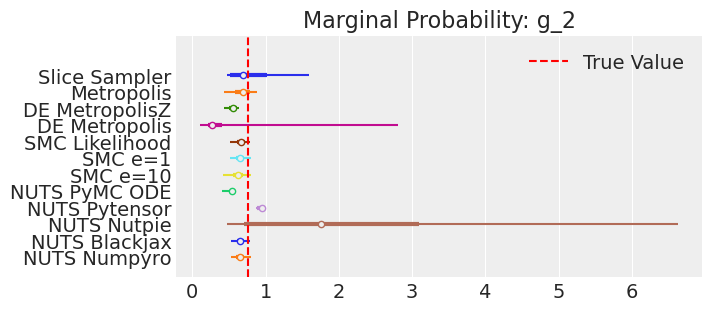

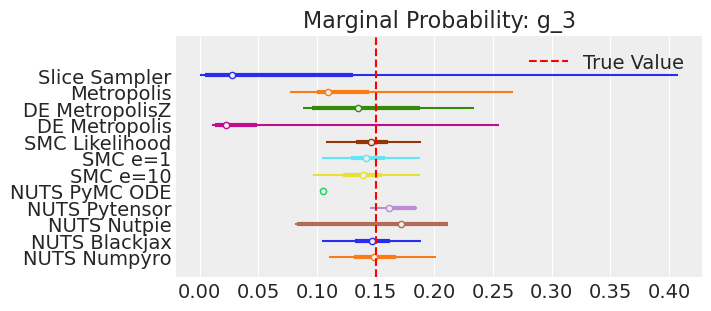

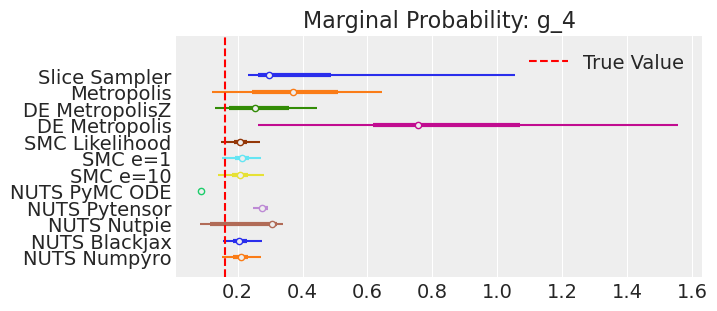

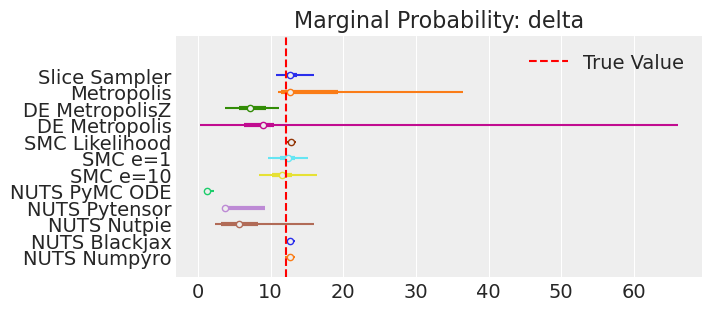

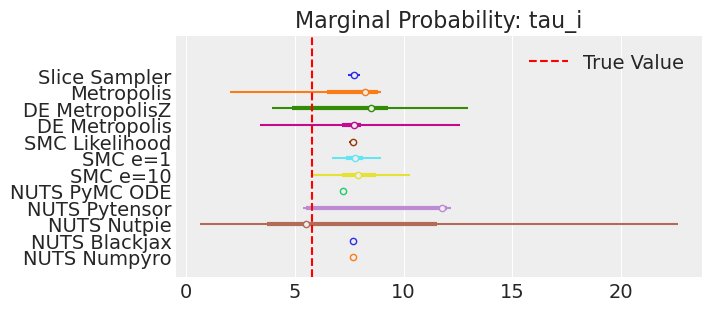

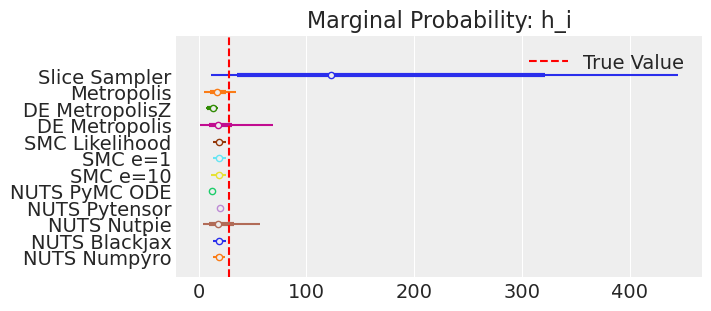

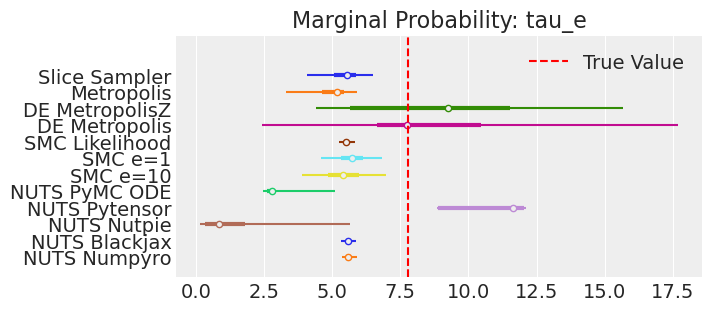

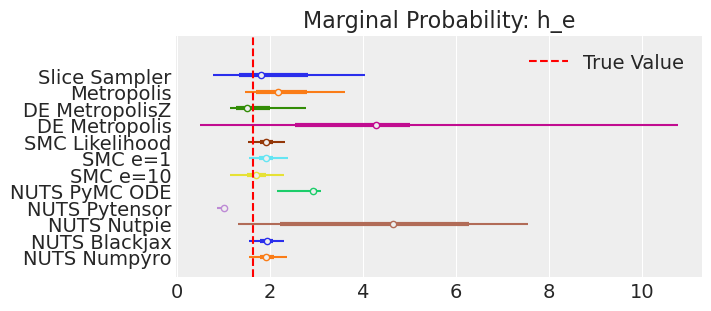

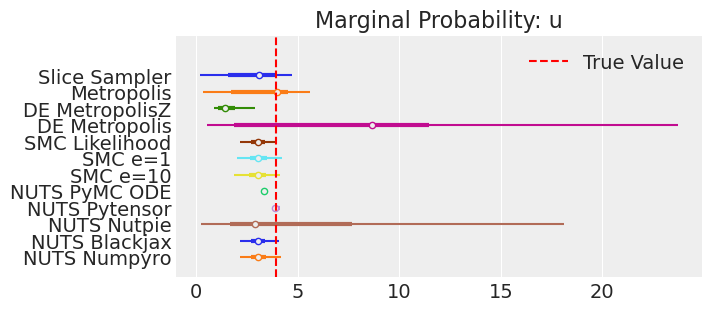

In [140]:
for var_name, true_value in zip(my_var_names, theta_true):
    axes = az.plot_forest(
        inference_results,
        model_names=model_names,
        var_names=var_name,
        kind="forestplot",
        legend=False,
        combined=True,
        figsize=(7, 3),)
    
    for ax in axes:
        ax.axvline(true_value, color='red', linestyle='--', label='True Value')
        ax.set_title(f"Marginal Probability: {var_name}")
        ylabels = ax.get_yticklabels()
        new_ylabels = []
        for label in ylabels:
            txt = label.get_text()
            txt = txt.replace(": " + var_name, "")
            label.set_text(txt)
            new_ylabels.append(label)
        ax.set_yticklabels(new_ylabels)
        ax.legend(loc='upper right')
    
plt.show()


In [141]:
inference_ess_bulk = [
    az.ess(trace, method="bulk").to_array().values.mean() /30 if model_name == "DE Metropolis"
    else az.ess(trace, method="bulk").to_array().values.mean() *40 if model_name == "NUTS PyMC ODE"    
    else az.ess(trace, method="bulk").to_array().values.mean() *40 if model_name == "NUTS Pytensor"    
    else az.ess(trace, method="bulk").to_array().values.mean()
    for model_name, trace in zip(model_names, inference_results)]


In [142]:
inference_ess_tail = [
    az.ess(trace, method="tail").to_array().values.mean() /30 if model_name == "DE Metropolis"
    else az.ess(trace, method="tail").to_array().values.mean() *40 if model_name == "NUTS PyMC ODE"    
    else az.ess(trace, method="tail").to_array().values.mean() *40 if model_name == "NUTS Pytensor"    
    else az.ess(trace, method="tail").to_array().values.mean()
    for model_name, trace in zip(model_names, inference_results)]


In [143]:
inference_data_ess = {
    model_names[i]: {
        "ess_tails_bulk": inference_ess_bulk[i],
        "ess_tails_tail": inference_ess_tail[i],} 
                    for i in range(len(model_names))}

df_ess = pd.DataFrame.from_dict(inference_data_ess, orient='index')

In [144]:
crudetime_values= [crudetime_slice, crudetime_M, crudetime_DEMZ, crudetime_DEM, 
                       crudetime_SMC_like, crudetime_SMC_e1, crudetime_SMC_e10, 
                       40*crudetime_nuts_pymc_ode, 
                       4*crudetime_nuts_pytensor_scan_pymc, 
                       crudetime_nuts_pytensor_scan_nutpie, 
                       crudetime_nuts_pytensor_scan_blackjax, 
                       crudetime_nuts_pytensor_scan_numpyro] 


rmse_params_values = [
    rmse_params_slice, rmse_params_M,  rmse_params_DEMZ, rmse_params_DEM, 
    rmse_params_SMC_like, rmse_params_SMC_e1, rmse_params_SMC_e10, 
    rmse_params_nuts_pymc_ode, 
    rmse_params_nuts_pytensor_scan_pymc, 
    rmse_params_nuts_pytensor_scan_nutpie,
    rmse_params_nuts_pytensor_scan_blackjax, 
    rmse_params_nuts_pytensor_scan_numpyro
]

rmse_fit_values = [
    rmse_fit_slice, rmse_fit_M, rmse_fit_DEMZ, rmse_fit_DEM, 
    rmse_fit_SMC_like, rmse_fit_SMC_e1, rmse_fit_SMC_e10, 
    rmse_fit_nuts_pymc_ode,
    rmse_fit_nuts_pytensor_scan_pymc, 
    rmse_fit_nuts_pytensor_scan_nutpie,
    rmse_fit_nuts_pytensor_scan_blackjax, 
    rmse_fit_nuts_pytensor_scan_numpyro
]

/tmp/ipykernel_357752/1563144988.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_names, rotation=90)
/tmp/ipykernel_357752/1563144988.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_names, rotation=90)
/tmp/ipykernel_357752/1563144988.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_names, rotation=90)
/tmp/ipykernel_357752/1563144988.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_names, rotation=90)


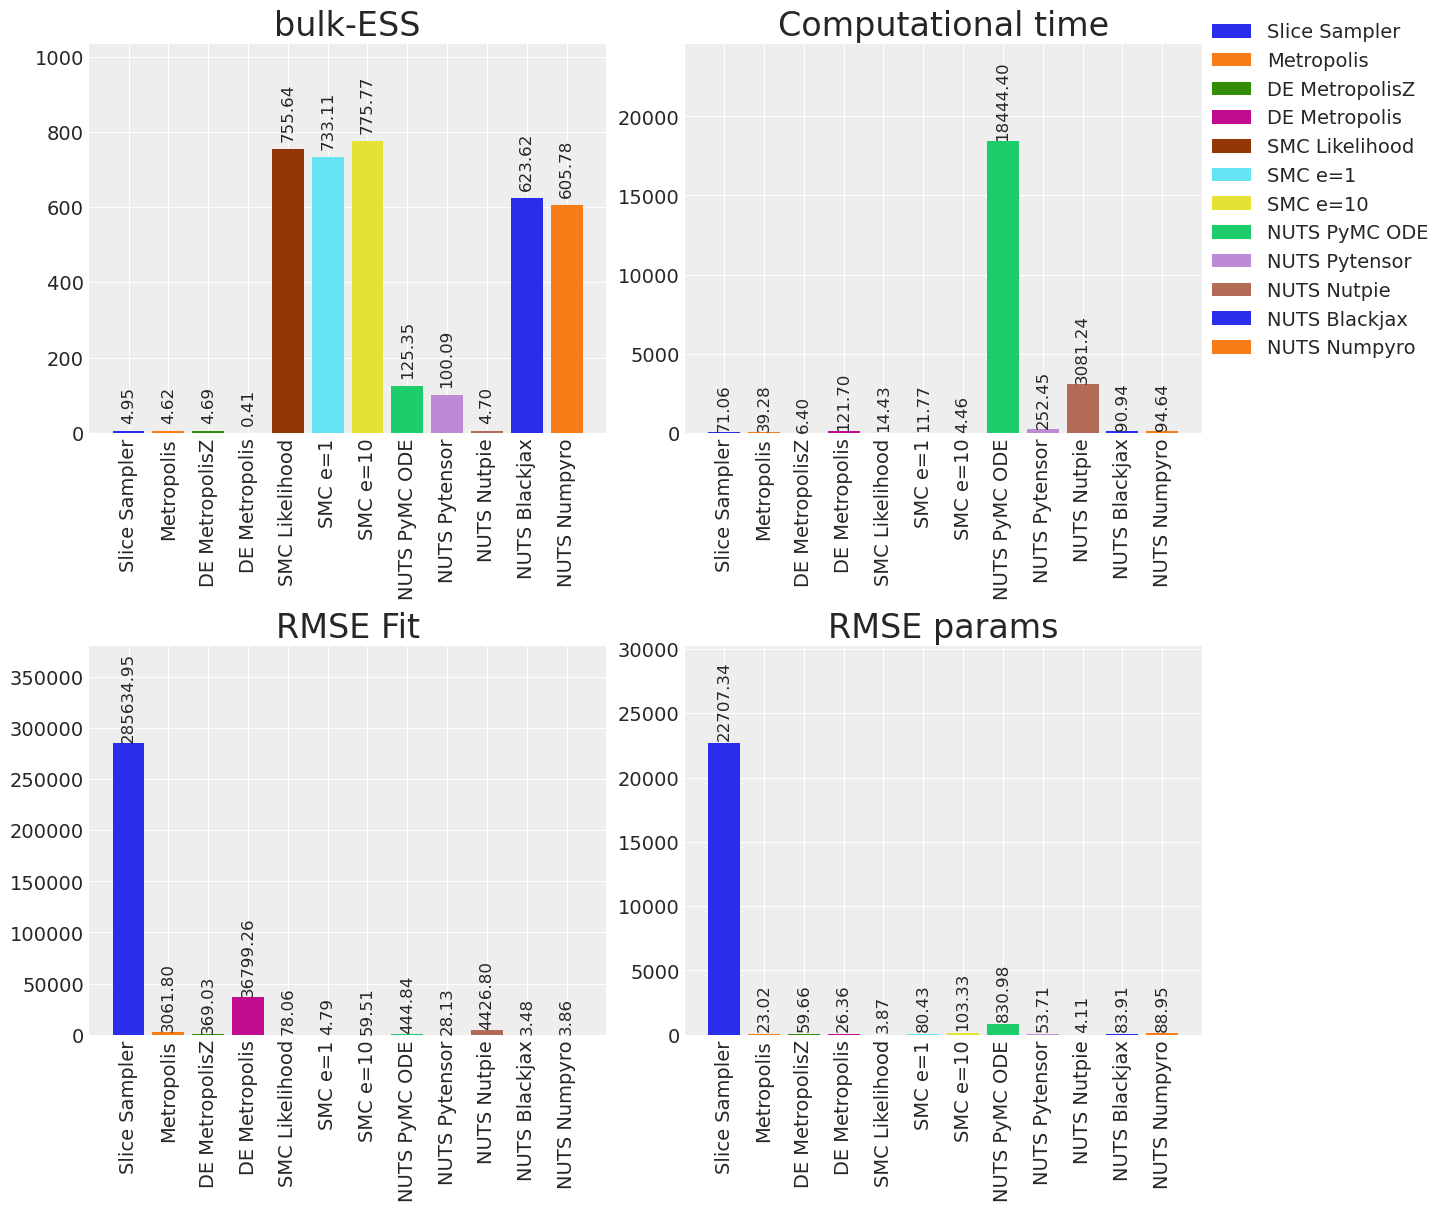

In [145]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot 1: Bulk effective sample size (bulk-ESS)
for i, (name, data) in enumerate(zip(model_names, inference_ess_bulk)):
    ax = axes[0, 0] if i < len(model_names) // 2 else axes[0, 0]
    ax.bar(name, data, label=name)
    ax.text(i, data + 20, f'{data:.2f}', ha='center', va='bottom', rotation=90, fontsize=12)
ax.set_title('bulk-ESS' , fontsize=24)
ax.set_xticklabels(model_names, rotation=90)
ax.set_ylim(0, (4/3)*np.max(inference_ess_bulk))

# Plot 2: Computational time
for i, (name, data) in enumerate(zip(model_names, crudetime_values)):
    ax = axes[0, 1] if i < len(model_names) // 2 else axes[0, 1]
    ax.bar(name, data, label=name)
    ax.text(i, data + 50, f'{data:.2f}', ha='center', va='bottom', rotation=90, fontsize=12)
ax.set_title('Computational time', fontsize=24)
ax.set_xticklabels(model_names, rotation=90)
ax.set_ylim(0, (4/3)*np.max(crudetime_values))

# Plot 3: RMSE fit
for i, (name, data) in enumerate(zip(model_names, rmse_fit_values)):
    ax = axes[1, 0] if i < len(model_names) // 2 else axes[1, 0]
    ax.bar(name, data, label=name)
    ax.text(i, data + 500, f'{data:.2f}', ha='center', va='bottom', rotation=90, fontsize=12)
ax.set_title('RMSE Fit', fontsize=24)
ax.set_xticklabels(model_names, rotation=90)
ax.set_ylim(0, (4/3)*np.max(rmse_fit_values))

# Plot 4: RMSE params
for i, (name, data) in enumerate(zip(model_names, rmse_params_values)):
    ax = axes[1, 1] if i < len(model_names) // 2 else axes[1, 1]
    ax.bar(name, data, label=name)
    ax.text(i, data + 200, f'{data:.2f}', ha='center', va='bottom', rotation=90, fontsize=12)
ax.set_title('RMSE params', fontsize=24)
ax.set_xticklabels(model_names, rotation=90)
ax.set_ylim(0, (4/3)*np.max(rmse_params_values))

fig.legend(model_names, loc='upper right', bbox_to_anchor=(1.2, 1))

plt.tight_layout()
plt.show()

In [146]:
Metrics_eval_data = {}
for i, model_name in enumerate(model_names):
    Metrics_eval_data[model_name] = {
        "ess_tails_bulk": inference_ess_bulk[i],
        "ess_tails_tail": inference_ess_tail[i],
        "crudetime": crudetime_values[i],
        "rmse_params": rmse_params_values[i],
        "rmse_fit": rmse_fit_values[i]}

In [147]:
df_metrics = pd.DataFrame.from_dict(Metrics_eval_data, orient='index')
df_metrics

ess_tails_bulk  ess_tails_tail     crudetime   rmse_params  \
Slice Sampler         4.947747       18.952333     71.064303  22707.338797   
Metropolis            4.622151        7.521866     39.276376     23.017261   
DE MetropolisZ        4.686640       13.838598      6.404309     59.664479   
DE Metropolis         0.407714        0.412714    121.703014     26.362526   
SMC Likelihood      755.635197      783.122965     14.434098      3.870848   
SMC e=1             733.106460      725.005653     11.770658     80.432679   
SMC e=10            775.769229      763.261002      4.460296    103.329530   
NUTS PyMC ODE       125.345239      816.326531  18444.395485    830.975922   
NUTS Pytensor       100.088915      900.052329    252.450379     53.713657   
NUTS Nutpie           4.703026       14.655285   3081.240113      4.111607   
NUTS Blackjax       623.617681      501.935314     90.941132     83.911991   
NUTS Numpyro        605.783721      504.957654     94.641551     88.947499   

                     rmse_fit  
Slice Sampler   285634.952888  
Metropolis        3061.802570  
DE MetropolisZ     369.030980  
DE Metropolis    36799.259612  
SMC Likelihood      78.060143  
SMC e=1              4.788293  
SMC e=10            59.513523  
NUTS PyMC ODE      444.843156  
NUTS Pytensor       28.131355  
NUTS Nutpie       4426.796202  
NUTS Blackjax        3.484227  
NUTS Numpyro         3.864276

**Notes:**  
If we ran the gradient-based  samplers for long enough to get good inferences, we would expect them to converge on the same posterior probability distributions. This is not necessarily true for Aproximate Bayssian Computation or gradient-free (with such a dimention and degeneracy). 

In sum, the results indicates SMC is a winner in gradient-free samplers, but needs tunning the acceptance rate. 
For the use of gradient-based, the  NUTS implementation with Pytensor Scan and the sampling from JAX's family such as blackjax and Numpyro is the winner.

In this notebook we ran all samplers with initial condition at mean prior. Neverthelss, the multimodality will happen with random initializaton. In this case, wighted stacking the chains is a robust solution.

### Key Conclusions
We performed Bayesian inference on a system of ODEs in 4 main ways: 
* Scipy `odeint` wrapped in a Pytensor `op` and sampled with non-gradient-based samplers (comparing 5 different samplers).  
* Scipy `odeint` wrapped in a `pm.Simulator` function and sampled with a non-likelihood-based sequential Monte Carlo (SMC) sampler.  
* PyMC `ode.DifferentialEquation` sampled with NUTs.  
* Forward simulation using `pytensor.scan` and sampled with NUTs (pymc, nutpie, and blackjax).  

The "winner" for this problem was Pytensor Pytensor Scan NUTs using Blackjax/Numpyro.


## Watermark

In [148]:
%watermark -n -u -v -iv -w

Last updated: Tue Apr 30 2024

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.15.0

numpy     : 1.25.2
pytensor  : 2.18.6
pandas    : 2.2.1
sys       : 3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:24:40) [GCC 10.4.0]
matplotlib: 3.6.2
arviz     : 0.18.0
pymc      : 5.11.0

Watermark: 2.4.3



### Installation

In [149]:
#conda create -c conda-forge -n pymc_env "pymc>=5"
#conda activate pymc_env
#conda install -c anaconda ipykernel
#pip install nutpie
#pip install numba
#pip install numpyro
#pip install blackjax
#pip install watermark
#sudo apt-get install graphviz

#in the case of conflict for samplers
#pip install pymc==5.11.0
#pip install numpy==1.26.
